<a href="https://colab.research.google.com/github/siris11/Time-series_hydrological-dynamics/blob/main/ID_7197000_mixed_humid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import shap
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [3]:
from zipfile import ZipFile
import os

# === CONFIGURATION ===
site_id = "ID_7197000"
usgs_code = site_id.split("_")[1]
zip_path = f"/content/{site_id}.zip"
unzip_dir = "/content/data_unzipped"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# List all files extracted
for root, dirs, files in os.walk(unzip_dir):
    for file in files:
        print(os.path.join(root, file))


/content/data_unzipped/ID_7197000/Climate_7197000.csv
/content/data_unzipped/ID_7197000/LULC_7197000.csv
/content/data_unzipped/ID_7197000/Baseflow_cumec.csv
/content/data_unzipped/ID_7197000/Streamflow_7197000.csv
/content/data_unzipped/ID_7197000/SW_ID_5026.csv
/content/data_unzipped/ID_7197000/SW_ID_5027.csv
/content/data_unzipped/ID_7197000/AET_mean_avg_7197000.csv
/content/data_unzipped/ID_7197000/Baseflow seperation/07197000_cfs.csv
/content/data_unzipped/ID_7197000/Baseflow seperation/baseflow.csv
/content/data_unzipped/ID_7197000/Documents/GW Major Aquifers.pdf
/content/data_unzipped/ID_7197000/Codes/Streamflow missing values calculation.R
/content/data_unzipped/ID_7197000/Codes/Recession constant estimation_7197000.R


In [4]:
usgs_code

'7197000'

In [5]:
import pandas as pd

#file paths
base_path = f"/content/data_unzipped/{site_id}"
files = {
    "aet": f"{base_path}/AET_mean_avg_{usgs_code}.csv",
    "streamflow": f"{base_path}/Streamflow_{usgs_code}.csv",
    "baseflow": f"{base_path}/Baseflow_cumec.csv",
    "climate": f"{base_path}/Climate_{usgs_code}.csv",
    "lulc": f"{base_path}/LULC_{usgs_code}.csv"
}

# Load each dataset
aet_df = pd.read_csv(files["aet"])
streamflow_df = pd.read_csv(files["streamflow"])
baseflow_df = pd.read_csv(files["baseflow"])
climate_df = pd.read_csv(files["climate"])
lulc_path = f"{base_path}/LULC_{usgs_code}.csv"
lulc_df = pd.read_csv(lulc_path)

# printing values
{
    "AET": aet_df.head(),
    "Streamflow": streamflow_df.head(),
    "Baseflow": baseflow_df.head(),
    "Climate": climate_df.head(),
    "LULC": lulc_df.head()
}


{'AET':          date  AET_mean
 0  1950-01-01  0.474724
 1  1950-02-01  0.712690
 2  1950-03-01  1.328809
 3  1950-04-01  2.152614
 4  1950-05-01  2.979788,
 'Streamflow':          date     cumec
 0  01/01/1951  1.047722
 1  01/02/1951  1.217622
 2  01/03/1951  1.245939
 3  01/04/1951  1.245939
 4  01/05/1951  1.217622,
 'Baseflow':           day  Baseflow(cumec)
 0  01/01/1951         0.523861
 1  01/02/1951         0.395020
 2  01/03/1951         0.346032
 3  01/04/1951         0.325644
 4  01/05/1951         0.313184,
 'Climate':          date       prcp      tmin       tmax
 0  1951-01-01   0.000000  2.802026  11.750343
 1  1951-01-02   9.051191  5.251260  14.339362
 2  1951-01-03  11.753397 -0.385196   9.889122
 3  1951-01-04   0.059929 -3.013536  12.217839
 4  1951-01-05   0.000000 -0.010767  16.651115,
 'LULC':    year  urbn  agrl    past    fomi  rngb  rnge  wehb    wetn    bsvg
 0  1951   0.0   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015
 1  1952   0.0   0.0  0.6054

In [6]:
print(aet_df.info())
print('\n')
print(streamflow_df.info())
print('\n')
print(baseflow_df.info())
print('\n')
print(climate_df.info())
print('\n')
print(lulc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      825 non-null    object 
 1   AET_mean  825 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25963 entries, 0 to 25962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    25568 non-null  object 
 1   cumec   25568 non-null  float64
dtypes: float64(1), object(1)
memory usage: 405.8+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25568 entries, 0 to 25567
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   day              25568 non-null  object 
 1   Baseflow(cumec)  25568 non-null  float64
dtypes: float64(1), object(1)
memory usage: 399.6+ KB
None


<class 'pa

In [7]:
# Converting to datetime
aet_df['date'] = pd.to_datetime(aet_df['date'])
streamflow_df['date'] = pd.to_datetime(streamflow_df['date'], format='%m/%d/%Y')
baseflow_df['date'] = pd.to_datetime(baseflow_df['day'], format='%m/%d/%Y')
climate_df['date'] = pd.to_datetime(climate_df['date'])

# Add 'year' column for grouping
aet_df['year'] = aet_df['date'].dt.year
streamflow_df['year'] = streamflow_df['date'].dt.year
baseflow_df['year'] = baseflow_df['date'].dt.year
climate_df['year'] = climate_df['date'].dt.year

# Aggregate to yearly data
aet_yearly = aet_df.groupby('year')['AET_mean'].mean().reset_index()
streamflow_yearly = streamflow_df.groupby('year')['cumec'].mean().reset_index()
baseflow_yearly = baseflow_df.groupby('year')['Baseflow(cumec)'].mean().reset_index()
climate_yearly = climate_df.groupby('year').agg({
    'prcp': 'mean',     # Total precipitation per year
    'tmin': 'mean',    # Average yearly minimum temperature
    'tmax': 'mean'     # Average yearly maximum temperature
}).reset_index()

{
    "AET Yearly": aet_yearly.head(),
    "Streamflow Yearly": streamflow_yearly.head(),
    "Baseflow Yearly": baseflow_yearly.head(),
    "Climate Yearly": climate_yearly.head(),
    "LULC": lulc_df.head()
}


{'AET Yearly':    year  AET_mean
 0  1950  2.257428
 1  1951  2.028859
 2  1952  1.908477
 3  1953  1.871134
 4  1954  1.665417,
 'Streamflow Yearly':      year     cumec
 0  1951.0  7.488281
 1  1952.0  5.194477
 2  1953.0  5.245994
 3  1954.0  2.779662
 4  1955.0  6.463810,
 'Baseflow Yearly':    year  Baseflow(cumec)
 0  1951         1.872767
 1  1952         1.299207
 2  1953         1.311664
 3  1954         0.688403
 4  1955         1.622558,
 'Climate Yearly':    year      prcp      tmin       tmax
 0  1951  3.226878  7.996280  20.337868
 1  1952  2.344262  7.982124  21.795624
 2  1953  2.493274  8.663861  22.165910
 3  1954  2.214184  8.948323  23.143499
 4  1955  2.458333  8.311573  21.288815,
 'LULC':    year  urbn  agrl    past    fomi  rngb  rnge  wehb    wetn    bsvg
 0  1951   0.0   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015
 1  1952   0.0   0.0  0.6054  0.3887   0.0   0.0   0.0  0.0044  0.0015
 2  1953   0.0   0.0  0.5850  0.4091   0.0   0.0   0.0  0.0044  0.0

In [8]:
print(climate_yearly['year'].unique())
print(aet_yearly['year'].unique())
print(streamflow_yearly['year'].unique())
print(baseflow_yearly['year'].unique())

[1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023]
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
[1951. 1952. 1953. 1954. 1955. 1956. 1957. 1958. 1959. 1960. 1961. 1962.
 1963. 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973. 1974.
 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985. 1986.
 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 199

In [9]:
#lulc_df = pd.read_csv("/content/data_unzipped/ID_5525500/LULC_05525500.csv")
lulc_path = f"{base_path}/LULC_{usgs_code}.csv"
lulc_df = pd.read_csv(lulc_path)
lulc_df

year    urbn  agrl    past    fomi  rngb  rnge  wehb    wetn    bsvg
0   1951  0.0000   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015
1   1952  0.0000   0.0  0.6054  0.3887   0.0   0.0   0.0  0.0044  0.0015
2   1953  0.0000   0.0  0.5850  0.4091   0.0   0.0   0.0  0.0044  0.0015
3   1954  0.0000   0.0  0.5926  0.4015   0.0   0.0   0.0  0.0044  0.0015
4   1955  0.0000   0.0  0.5845  0.4096   0.0   0.0   0.0  0.0044  0.0015
..   ...     ...   ...     ...     ...   ...   ...   ...     ...     ...
65  2016  0.0178   0.0  0.6756  0.3008   0.0   0.0   0.0  0.0044  0.0015
66  2017  0.0178   0.0  0.6779  0.2984   0.0   0.0   0.0  0.0044  0.0015
67  2018  0.0178   0.0  0.6753  0.3011   0.0   0.0   0.0  0.0044  0.0015
68  2019  0.0192   0.0  0.6730  0.3019   0.0   0.0   0.0  0.0044  0.0015
69  2020  0.0192   0.0  0.6713  0.3036   0.0   0.0   0.0  0.0044  0.0015

[70 rows x 10 columns]

In [10]:
# soil_files = [f for f in os.listdir(base_path) if f.startswith("SW_ID_") and f.endswith(".csv")]
# soil_file_paths = [os.path.join(base_path, f) for f in soil_files]

# null_counts = {}
# for path in soil_file_paths:
#     df = pd.read_csv(path)
#     null_counts[os.path.basename(path)] = df.isnull().sum()

# # Print missing values in each file
# for file, nulls in null_counts.items():
#     print(f"\nNull counts in {file}:\n{nulls}")

In [11]:
# # === SOIL MOISTURE CLEANING ===
# soil_files = [os.path.join(base_path, f) for f in os.listdir(base_path)
#                        if f.startswith("SW_ID_") and f.endswith(".csv")]

# soil_dfs = []
# for i, path in enumerate(soil_files):
#     df = pd.read_csv(path)
#     df['date'] = pd.to_datetime(df['date'])
#     df['year'] = df['date'].dt.year
#     df_yearly = df.groupby('year')['soil_moisture'].mean().reset_index()
#     df_yearly.columns = ['year', f'soil_{8795+i}']
#     soil_dfs.append(df_yearly)

# # Merge all three soil moisture DataFrames on 'year'
# soil_combined = soil_dfs[0]
# for df in soil_dfs[1:]:
#     soil_combined = soil_combined.merge(df, on='year', how='outer')

# # Compute average soil moisture across the three sites
# soil_combined['soil_moisture_avg'] = soil_combined.iloc[:, 1:4].mean(axis=1)

# soil_yearly = soil_combined[['year', 'soil_moisture_avg']]

# soil_yearly.head()

In [12]:
# Merge all into one modeling DataFrame
df = aet_yearly \
    .merge(baseflow_yearly, on='year') \
    .merge(streamflow_yearly, on='year') \
    .merge(climate_yearly, on='year') \
    .merge(lulc_df, on='year')

#df = df.dropna()
print(df.head())

   year  AET_mean  Baseflow(cumec)     cumec      prcp      tmin       tmax  \
0  1951  2.028859         1.872767  7.488281  3.226878  7.996280  20.337868   
1  1952  1.908477         1.299207  5.194477  2.344262  7.982124  21.795624   
2  1953  1.871134         1.311664  5.245994  2.493274  8.663861  22.165910   
3  1954  1.665417         0.688403  2.779662  2.214184  8.948323  23.143499   
4  1955  2.183959         1.622558  6.463810  2.458333  8.311573  21.288815   

   urbn  agrl    past    fomi  rngb  rnge  wehb    wetn    bsvg  
0   0.0   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015  
1   0.0   0.0  0.6054  0.3887   0.0   0.0   0.0  0.0044  0.0015  
2   0.0   0.0  0.5850  0.4091   0.0   0.0   0.0  0.0044  0.0015  
3   0.0   0.0  0.5926  0.4015   0.0   0.0   0.0  0.0044  0.0015  
4   0.0   0.0  0.5845  0.4096   0.0   0.0   0.0  0.0044  0.0015  


In [13]:
df.isnull().sum()

year               0
AET_mean           0
Baseflow(cumec)    0
cumec              0
prcp               0
tmin               0
tmax               0
urbn               0
agrl               0
past               0
fomi               0
rngb               0
rnge               0
wehb               0
wetn               0
bsvg               0
dtype: int64

In [14]:
unique_years = df['year'].nunique()
unique_years #1979-2018
#print(f"Unique years range from {unique_years.min()} to {unique_years.max()}")

68

In [15]:
df.head()

year  AET_mean  Baseflow(cumec)     cumec      prcp      tmin       tmax  \
0  1951  2.028859         1.872767  7.488281  3.226878  7.996280  20.337868   
1  1952  1.908477         1.299207  5.194477  2.344262  7.982124  21.795624   
2  1953  1.871134         1.311664  5.245994  2.493274  8.663861  22.165910   
3  1954  1.665417         0.688403  2.779662  2.214184  8.948323  23.143499   
4  1955  2.183959         1.622558  6.463810  2.458333  8.311573  21.288815   

   urbn  agrl    past    fomi  rngb  rnge  wehb    wetn    bsvg  
0   0.0   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015  
1   0.0   0.0  0.6054  0.3887   0.0   0.0   0.0  0.0044  0.0015  
2   0.0   0.0  0.5850  0.4091   0.0   0.0   0.0  0.0044  0.0015  
3   0.0   0.0  0.5926  0.4015   0.0   0.0   0.0  0.0044  0.0015  
4   0.0   0.0  0.5845  0.4096   0.0   0.0   0.0  0.0044  0.0015

In [16]:
print(df['rngb'].value_counts())
print(df['wehb'].value_counts())
print(df['bsvg'].value_counts())

rngb
0.0    68
Name: count, dtype: int64
wehb
0.0    68
Name: count, dtype: int64
bsvg
0.0015    68
Name: count, dtype: int64


In [17]:
features = list(df.columns)
print(features)

['year', 'AET_mean', 'Baseflow(cumec)', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl', 'past', 'fomi', 'rngb', 'rnge', 'wehb', 'wetn', 'bsvg']


In [18]:
df.drop(columns=['rngb', 'wehb', 'bsvg','wetn'], axis=1, inplace=True)
df

year  AET_mean  Baseflow(cumec)      cumec      prcp      tmin       tmax  \
0   1951  2.028859         1.872767   7.488281  3.226878  7.996280  20.337868   
1   1952  1.908477         1.299207   5.194477  2.344262  7.982124  21.795624   
2   1953  1.871134         1.311664   5.245994  2.493274  8.663861  22.165910   
3   1954  1.665417         0.688403   2.779662  2.214184  8.948323  23.143499   
4   1955  2.183959         1.622558   6.463810  2.458333  8.311573  21.288815   
..   ...       ...              ...        ...       ...       ...        ...   
63  2014  2.102858         1.306115   5.221377  2.767057  7.629514  19.868077   
64  2015  2.528003         6.121820  24.694406  4.832098  9.262220  21.030194   
65  2016  2.172705         1.569577   6.061992  2.471822  9.444558  22.226700   
66  2017  2.192127         2.268280   9.073874  3.649082  9.255430  22.149000   
67  2018  2.587296         2.241411   8.992865  3.390632  8.752871  21.008536   

      urbn  agrl    past    fomi  rnge  
0   0.0000   0.0  0.6275  0.3667   0.0  
1   0.0000   0.0  0.6054  0.3887   0.0  
2   0.0000   0.0  0.5850  0.4091   0.0  
3   0.0000   0.0  0.5926  0.4015   0.0  
4   0.0000   0.0  0.5845  0.4096   0.0  
..     ...   ...     ...     ...   ...  
63  0.0178   0.0  0.6717  0.3047   0.0  
64  0.0178   0.0  0.6759  0.3005   0.0  
65  0.0178   0.0  0.6756  0.3008   0.0  
66  0.0178   0.0  0.6779  0.2984   0.0  
67  0.0178   0.0  0.6753  0.3011   0.0  

[68 rows x 12 columns]

In [19]:
df.to_csv('df.csv', index=False)

In [20]:
df = pd.read_csv('df.csv')
df.head()

year  AET_mean  Baseflow(cumec)     cumec      prcp      tmin       tmax  \
0  1951  2.028859         1.872767  7.488281  3.226878  7.996280  20.337868   
1  1952  1.908477         1.299207  5.194477  2.344262  7.982124  21.795624   
2  1953  1.871134         1.311664  5.245994  2.493274  8.663861  22.165910   
3  1954  1.665417         0.688403  2.779662  2.214184  8.948323  23.143499   
4  1955  2.183959         1.622558  6.463810  2.458333  8.311573  21.288815   

   urbn  agrl    past    fomi  rnge  
0   0.0   0.0  0.6275  0.3667   0.0  
1   0.0   0.0  0.6054  0.3887   0.0  
2   0.0   0.0  0.5850  0.4091   0.0  
3   0.0   0.0  0.5926  0.4015   0.0  
4   0.0   0.0  0.5845  0.4096   0.0

In [21]:
# === Units for reference ===
# year: Year (unitless)
# cumec: Streamflow (m³/s)
# Baseflow(cumec): Baseflow (m³/s)
# AET_mean: Actual Evapotranspiration (mm/day)
# prcp: Precipitation (mm)
# tmin, tmax: Temperature (°C)
# soil_moisture_avg: Soil Moisture (m³/m³)
# LULC variables (urbn, agrl, etc.): Land use fraction (0-1, unitless)

In [22]:
df.describe()

year   AET_mean  Baseflow(cumec)      cumec       prcp  \
count    68.00000  68.000000        68.000000  68.000000  68.000000   
mean   1984.50000   2.149041         2.314623   9.260244   3.196825   
std      19.77372   0.185048         1.217426   4.882420   0.677709   
min    1951.00000   1.665417         0.286161   1.140639   1.684649   
25%    1967.75000   2.019667         1.437121   5.747515   2.659425   
50%    1984.50000   2.162549         2.152115   8.625491   3.186263   
75%    2001.25000   2.267978         2.935132  11.783493   3.657147   
max    2018.00000   2.587296         6.121820  24.694406   5.269389   

            tmin       tmax       urbn  agrl       past       fomi  rnge  
count  68.000000  68.000000  68.000000  68.0  68.000000  68.000000  68.0  
mean    8.320082  20.965835   0.005538   0.0   0.624437   0.364196   0.0  
std     0.643508   0.832495   0.005658   0.0   0.033329   0.038428   0.0  
min     6.983481  19.687333   0.000000   0.0   0.572400   0.289500   0.0  
25%     7.940959  20.432711   0.000400   0.0   0.594450   0.333100   0.0  
50%     8.278805  20.783087   0.003900   0.0   0.617600   0.372700   0.0  
75%     8.755949  21.370716   0.008275   0.0   0.652925   0.397850   0.0  
max     9.956739  23.336032   0.017800   0.0   0.686900   0.421600   0.0

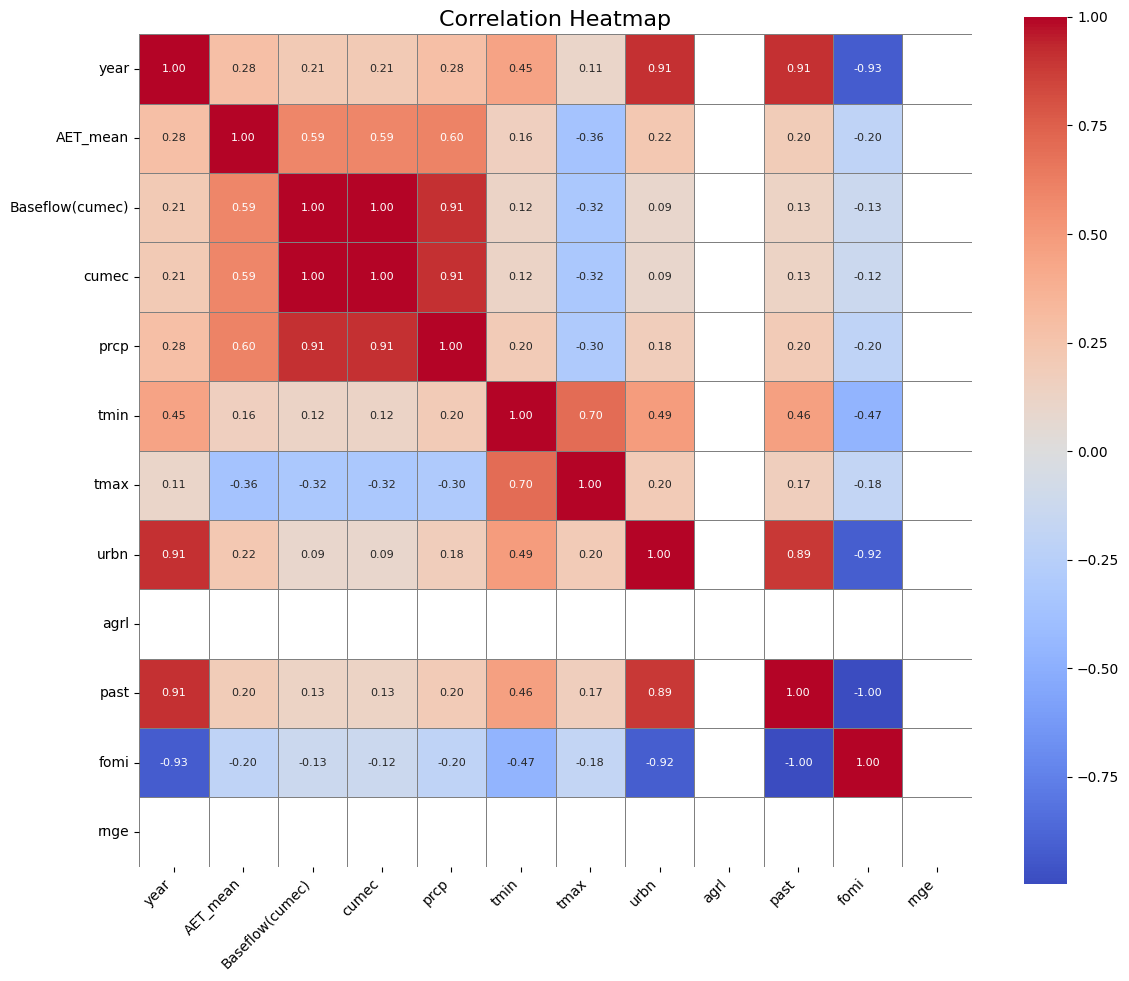

In [23]:
df_corr = df.dropna(axis=1, how='all')
df_corr = df_corr.loc[:, df_corr.nunique() > 1]

numerical_feats = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_feats.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar=True, linewidths=0.5, linecolor='gray',
            annot_kws={"size": 8}, mask=correlation_matrix.isnull())

plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- **Streamflow**, **Baseflow(cumec)**, and **prcp** show strong positive correlations (ρ ≈ 0.88–1.00), indicating that precipitation and baseflow are key contributors to streamflow.

- **soil_moisture_avg** is moderately correlated with **streamflow **(ρ ≈ 0.64), suggesting that wetter soils enhance runoff and flow.

- **tmin** and **tmax** have a strong positive correlation (ρ ≈ 0.84), reflecting consistent temperature trends.

- **agrl (agricultural land)** shows weak to moderate negative correlations with streamflow (ρ ≈ -0.26) and very strong inverse relation with** mge (ρ ≈ -0.96)**, indicating possible land cover trade-offs.

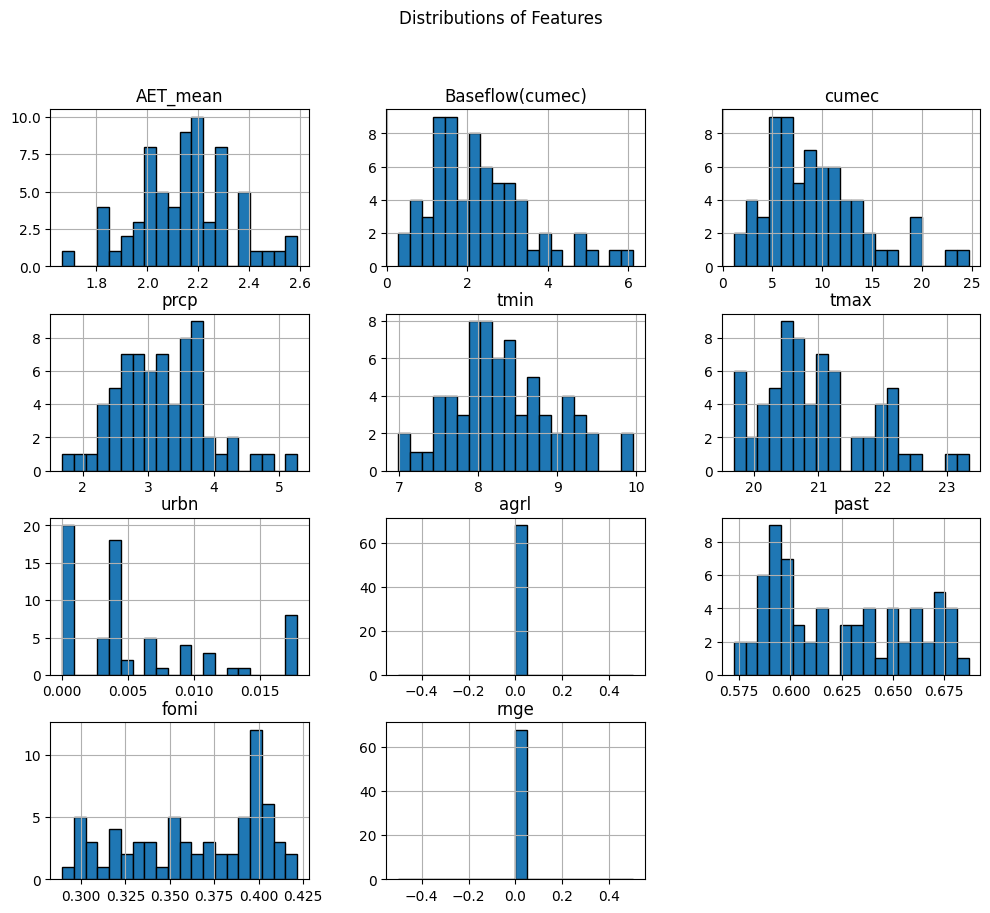

In [24]:
# Histogram of each feature
df.drop(columns='year').hist(bins=20, figsize=(12, 10), edgecolor='black')
plt.suptitle("Distributions of Features")
plt.show()

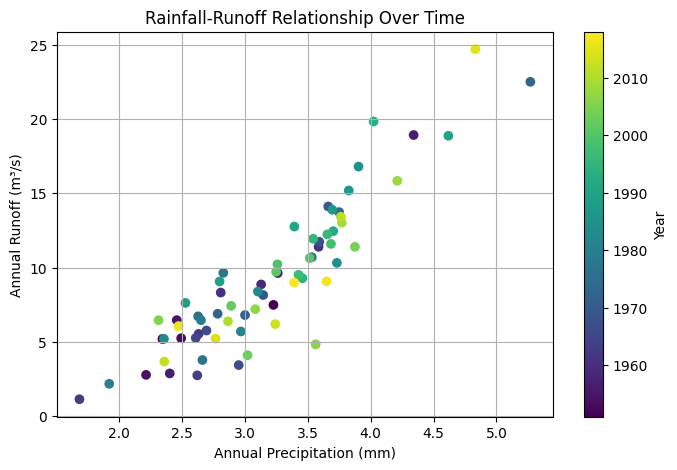

In [25]:
#Plot rainfall-runoff relationship over time
plt.figure(figsize=(8, 5))
plt.scatter(df['prcp'], df['cumec'], c=df['year'], cmap='viridis')
plt.xlabel("Annual Precipitation (mm)")
plt.ylabel("Annual Runoff (m³/s)")
plt.title("Rainfall-Runoff Relationship Over Time")
plt.colorbar(label='Year')
plt.grid(True)
plt.show()

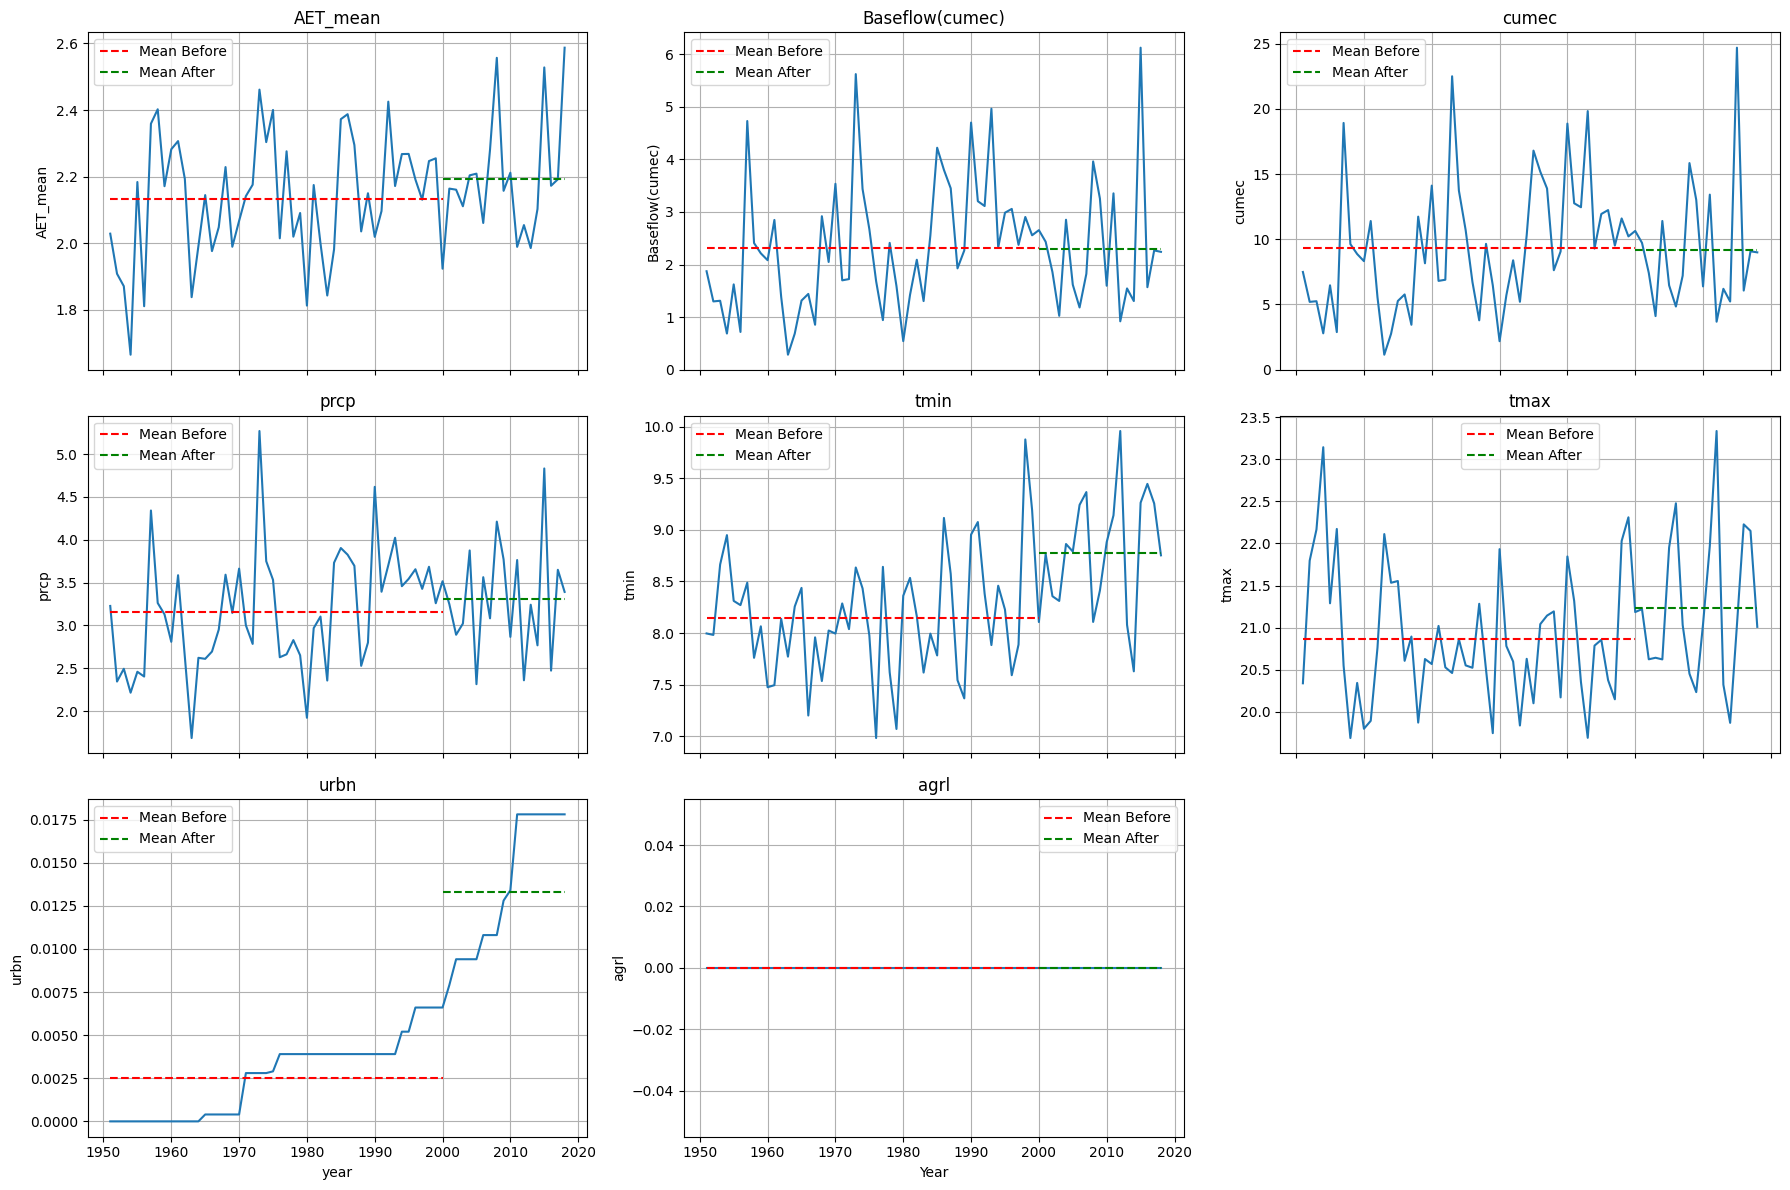

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['AET_mean','Baseflow(cumec)','cumec','prcp','tmin','tmax',
            'urbn','agrl']
change_point = 2000

n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Plot line
    sns.lineplot(x=df['year'], y=df[feature], ax=ax)

    # Mean before/after change point
    mean_before = df[df['year'] < change_point][feature].mean()
    mean_after = df[df['year'] >= change_point][feature].mean()

    # Horizontal mean lines
    ax.hlines(mean_before, xmin=df['year'].min(), xmax=change_point, colors='red', linestyles='dashed', label='Mean Before')
    ax.hlines(mean_after, xmin=change_point, xmax=df['year'].max(), colors='green', linestyles='dashed', label='Mean After')

    ax.set_title(f"{feature}")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend()

# Remove unused subplots if features < total grid size
for j in range(i + 1, len(axes)):
     fig.delaxes(axes[j])
plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def seq_mk(data):
    """
    Sequential Mann-Kendall test.
    Input: 2-column NumPy array or DataFrame with [year, values]
    Output: DataFrame with columns [u_prog, u_retr, turning_point]
    """
    year = data[:, 0]
    values = data[:, 1]
    m = len(values)

    # Progressive series
    n = np.zeros((m, m))
    for j in range(m):
        for i in range(j):
            n[j, i] = 1 if values[j] > values[i] else 0
    num = np.sum(n, axis=1)
    t = np.cumsum(num)
    var = np.array([i * (i - 1) * (2 * i + 5) / 72 for i in range(1, m + 1)])
    mean = np.array([i * (i - 1) / 4 for i in range(1, m + 1)])
    u_prog = (t - mean) / np.sqrt(var)

    # Retrograde series
    values_rev = values[::-1]
    n1 = np.zeros((m, m))
    for j in range(m):
        for i in range(j):
            n1[j, i] = 1 if values_rev[j] > values_rev[i] else 0
    num1 = np.sum(n1, axis=1)
    t1 = np.cumsum(num1)
    var1 = var
    mean1 = mean
    u_retr = (t1 - mean1) / np.sqrt(var1)
    u_retr = u_retr[::-1]

    # Turning points
    diff = u_prog - u_retr
    turning_point = np.zeros(m)
    for i in range(1, m - 2):
        if np.sign(diff[i]) != np.sign(diff[i + 1]):
            turning_point[i + 1] = 1

    # Plot
    # plt.figure(figsize=(10, 5))
    # plt.plot(year, u_prog, 'r', label='Progressive Series')
    # plt.plot(year, u_retr, 'b', label='Retrograde Series')
    # plt.grid(True)
    # plt.title('Sequential Mann-Kendall Test')
    # plt.xlabel('Year')
    # plt.legend()
    # plt.show()

    return pd.DataFrame({
        'year': year,
        'u_prog': u_prog,
        'u_retr': u_retr,
        'turning_point': turning_point.astype(int)
    })


In [28]:
#Applying S M Test to streamflow
df = pd.read_csv('df.csv')
data_array = df[['year', 'cumec']].to_numpy()
result = seq_mk(data_array)

# View detected change years
change_years = result[result['turning_point'] == 1]['year'].drop_duplicates().sort_values().astype(int).tolist()
print("Non-stationary turning point years:", change_years)

Non-stationary turning point years: [1954, 1955, 1956, 1957, 1965, 1971, 1980, 1991]


In [29]:
features = ['AET_mean','Baseflow(cumec)','cumec','prcp','tmin','tmax',
            'urbn','agrl']

for feat in features:
    print(f"Testing variable: {feat}")
    data_array = df[['year', feat]].to_numpy()
    result = seq_mk(data_array)
    turning_years = result[result['turning_point'] == 1]['year'].values
    if len(turning_years) > 0:
        print("Turning points found in year(s):", turning_years)
    else:
        print("No turning point found.")
    print('\n')

Testing variable: AET_mean
Turning points found in year(s): [1953. 1955. 1956. 1957. 1984. 1986.]


Testing variable: Baseflow(cumec)
Turning points found in year(s): [1954. 1955. 1956. 1957. 1965. 1971. 1980. 1991.]


Testing variable: cumec
Turning points found in year(s): [1954. 1955. 1956. 1957. 1965. 1971. 1980. 1991.]


Testing variable: prcp
Turning points found in year(s): [1983. 1986.]


Testing variable: tmin
No turning point found.


Testing variable: tmax
Turning points found in year(s): [1961. 1963. 1984. 1988. 1994. 2001. 2004. 2006. 2015.]


Testing variable: urbn
No turning point found.


Testing variable: agrl
Turning points found in year(s): [1985.]




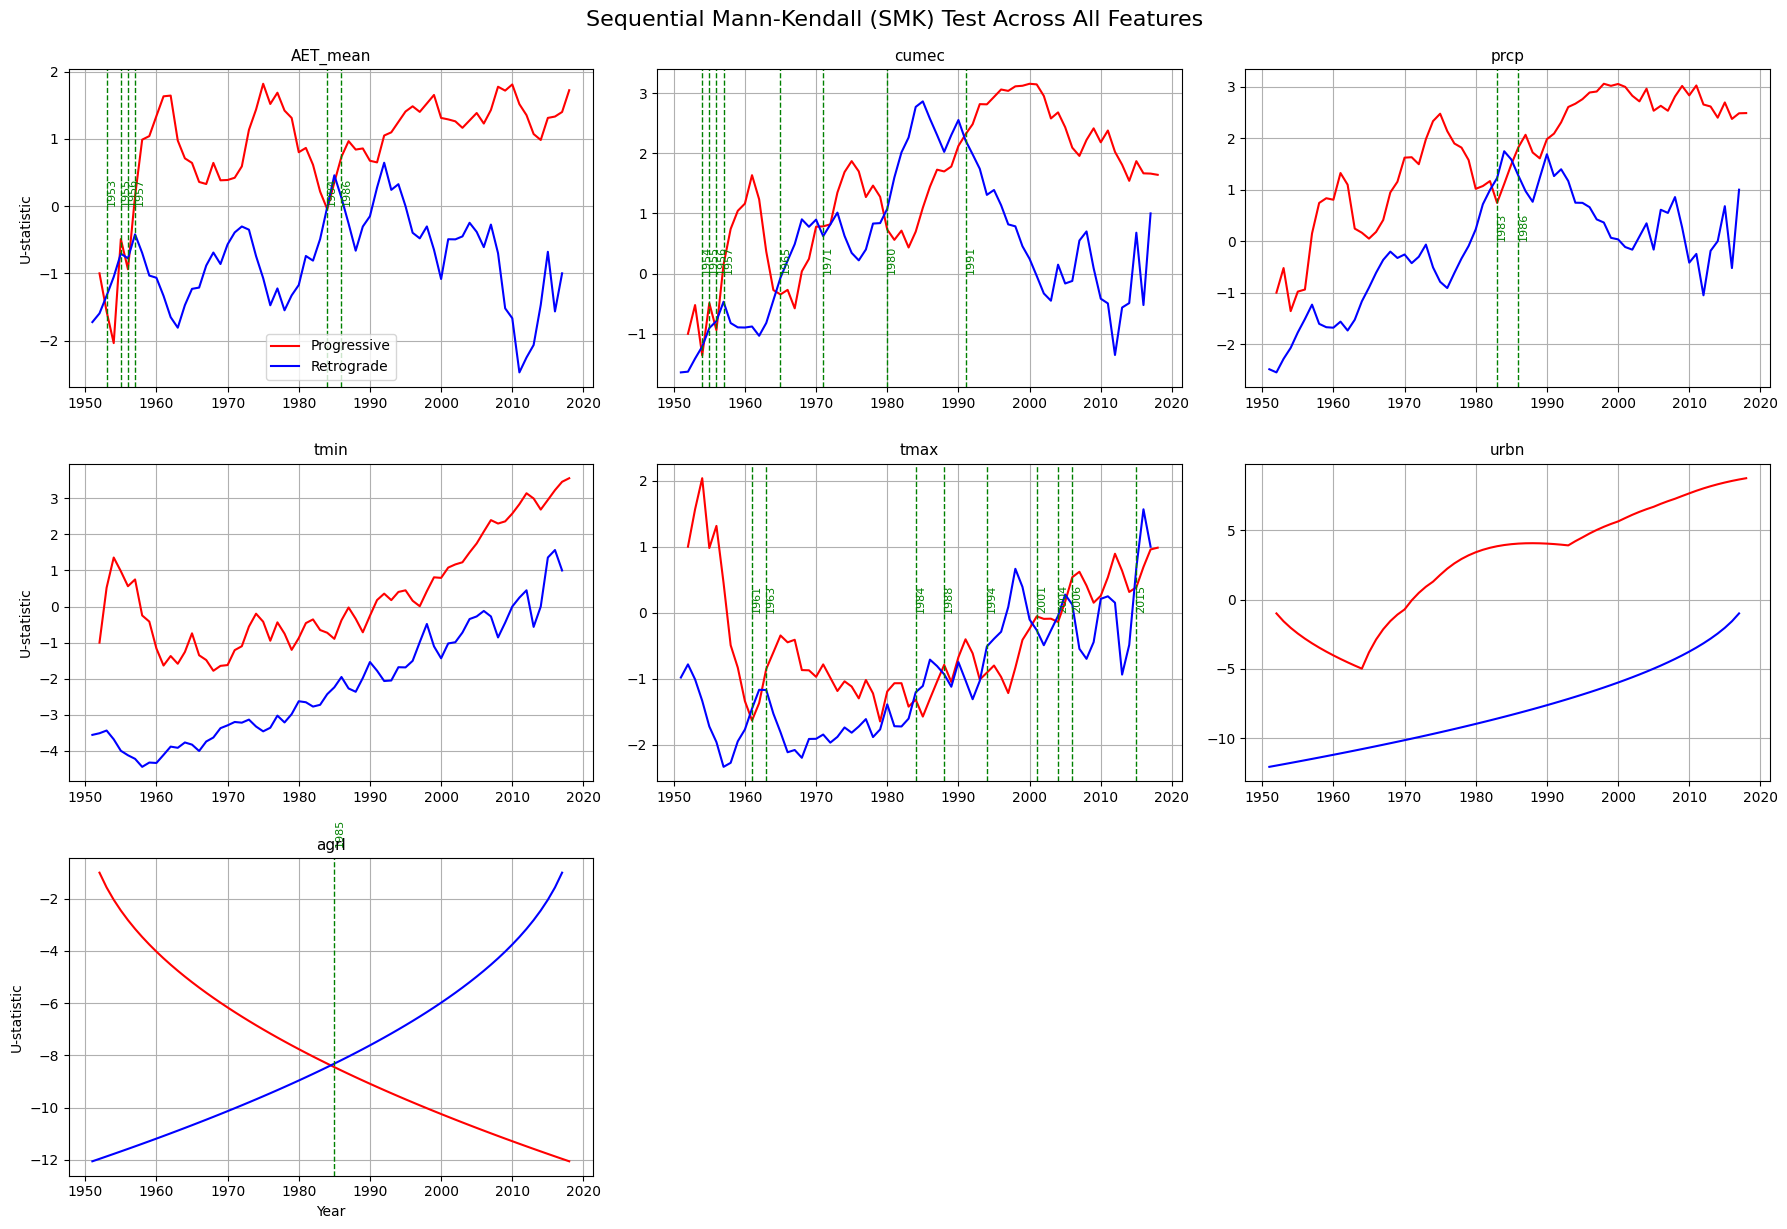

In [30]:
df = pd.read_csv("df.csv")

# List of features to analyze
features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax',
            'urbn', 'agrl']

# Plot configuration
cols = 3
rows = math.ceil(len(features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

# Sequential MK for each feature
for idx, feature in enumerate(features):
    ax = axes[idx]
    data_array = df[['year', feature]].to_numpy()
    result = seq_mk(data_array)

    year = result['year']
    u_prog = result['u_prog']
    u_retr = result['u_retr']
    turning_years = result[result['turning_point'] == 1]['year'].values

    ax.plot(year, u_prog, 'r', label='Progressive')
    ax.plot(year, u_retr, 'b', label='Retrograde')

    for ty in turning_years:
        ax.axvline(ty, color='green', linestyle='--', linewidth=1)
        ax.text(ty, 0, f'{int(ty)}', color='green', fontsize=8, rotation=90, va='bottom')

    ax.set_title(f"{feature}", fontsize=11)
    ax.grid(True)

    if idx % cols == 0:
        ax.set_ylabel("U-statistic")
    if idx >= (rows - 1) * cols:
        ax.set_xlabel("Year")

# Remove empty subplots if any
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Final touches
fig.tight_layout()
fig.suptitle("Sequential Mann-Kendall (SMK) Test Across All Features", fontsize=16, y=1.02)
axes[0].legend()
plt.show()

In [31]:
df['urban_precip'] = df['urbn'] * df['prcp']
df['urban_tmin'] = df['urbn'] * df['tmin']

In [32]:
# Dataset bounds
turning_points = change_years.copy()
start_year = 1953
end_year = 2018
min_interval_gap = 10  # minimum gap in years

# Step 1: Filter turning points with ~10-year separation
filtered_tp = []
last_added = 1953
for year in turning_points:
    if last_added is None or (year - last_added >= min_interval_gap):
        filtered_tp.append(year)
        last_added = year

# Step 2: Add start_year if far enough from first filtered_tp
if filtered_tp and (filtered_tp[0] - start_year >= min_interval_gap):
    filtered_tp = [start_year] + filtered_tp

# Step 3: Add end_year if needed
if filtered_tp[-1] < end_year:
    filtered_tp.append(end_year)

# Step 4: Form intervals
intervals = [(filtered_tp[i], filtered_tp[i + 1]) for i in range(len(filtered_tp) - 1)]

# Output
print("Filtered Turning Points:", filtered_tp)
print("Intervals:", intervals)

Filtered Turning Points: [1953, 1965, 1980, 1991, 2018]
Intervals: [(1953, 1965), (1965, 1980), (1980, 1991), (1991, 2018)]


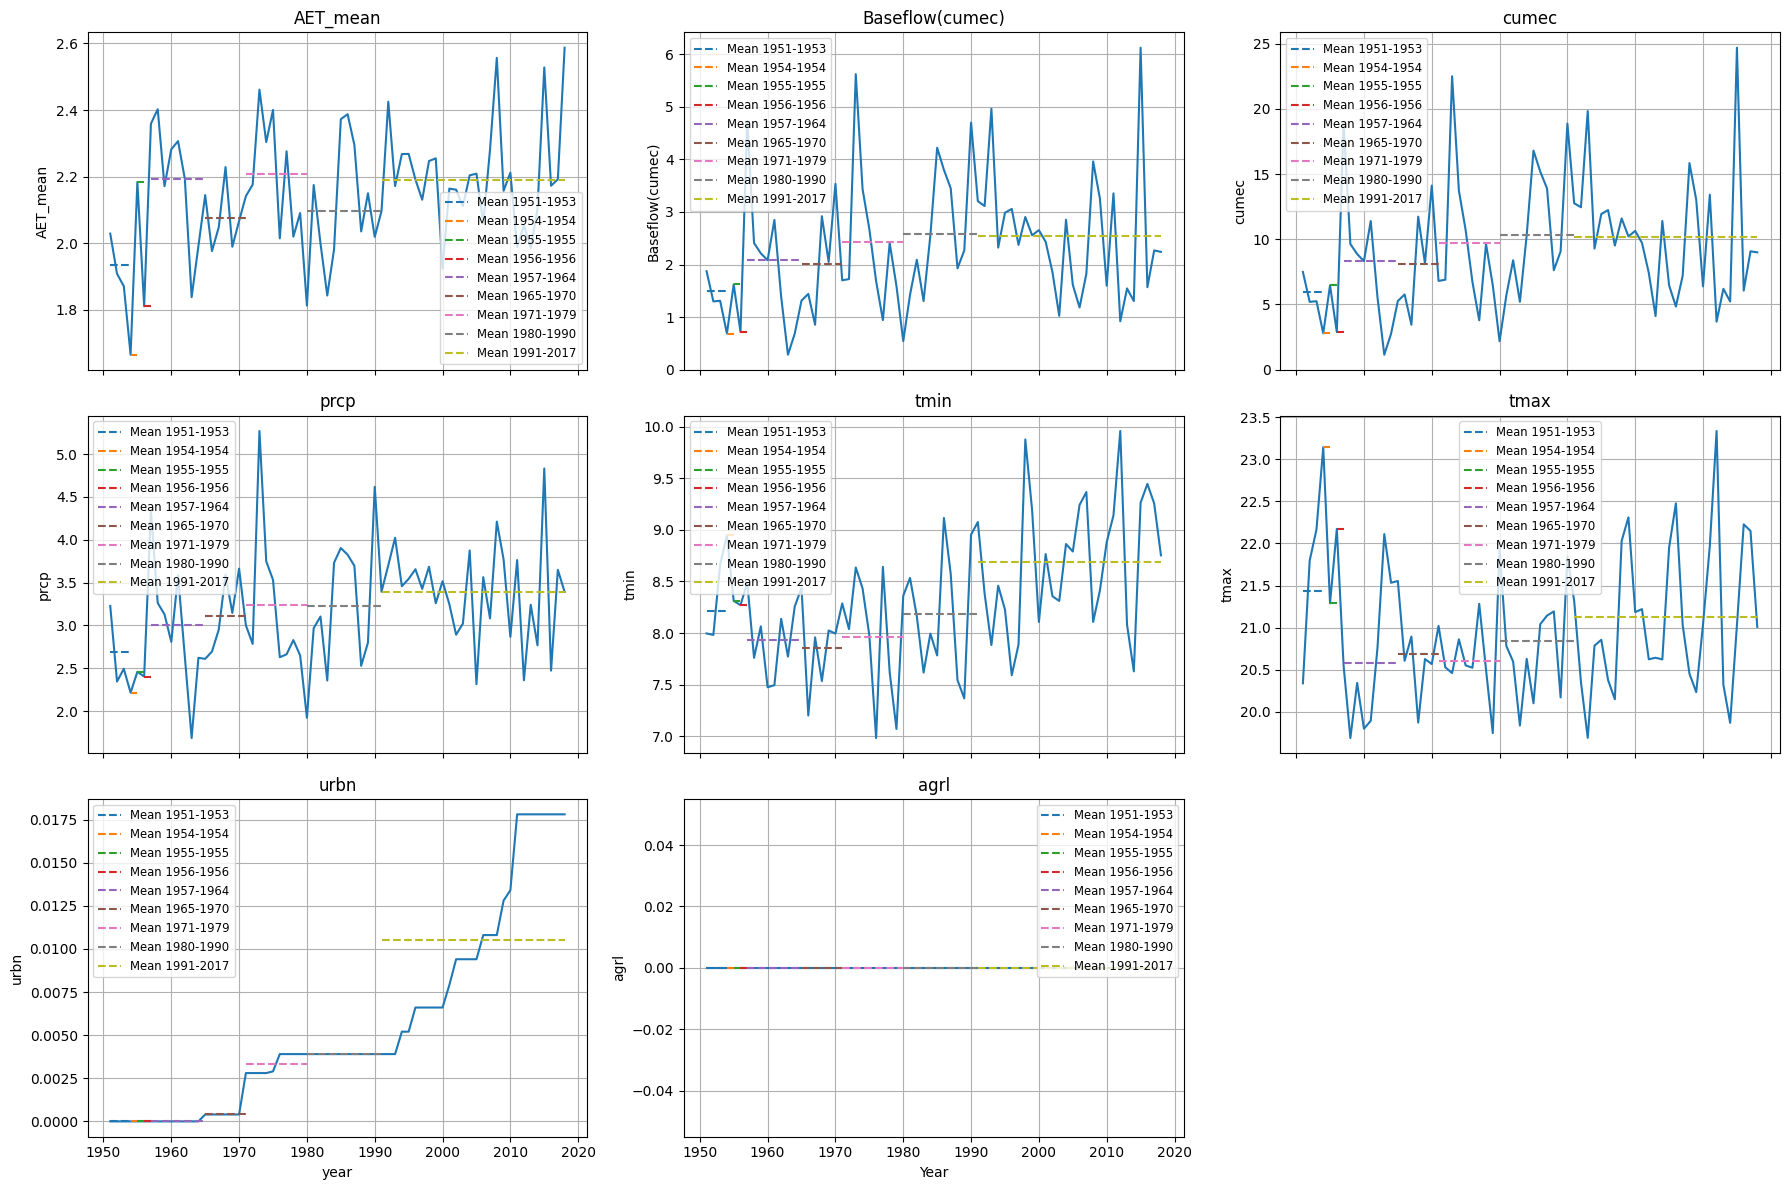

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

features = ['AET_mean', 'Baseflow(cumec)', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl']
change_points = turning_points
all_years = [df['year'].min()] + change_points + [df['year'].max()]

n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Plot time series
    sns.lineplot(x=df['year'], y=df[feature], ax=ax)

    # Plot means between change points
    for j in range(len(all_years) - 1):
        start_year = all_years[j]
        end_year = all_years[j + 1]

        mask = (df['year'] >= start_year) & (df['year'] < end_year)
        mean_val = df.loc[mask, feature].mean()

        ax.hlines(mean_val, xmin=start_year, xmax=end_year,
                  colors='C'+str(j), linestyles='dashed',
                  label=f'Mean {start_year}-{end_year-1}')

    ax.set_title(f"{feature}")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(fontsize='small')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Year")
plt.tight_layout()
plt.show()


# Model training

[1954, 1955, 1956, 1957, 1965, 1971, 1980, 1991]
 Processing interval: 1953 to 1965
 Processing interval: 1965 to 1980
 Processing interval: 1980 to 1991
 Processing interval: 1991 to 2018


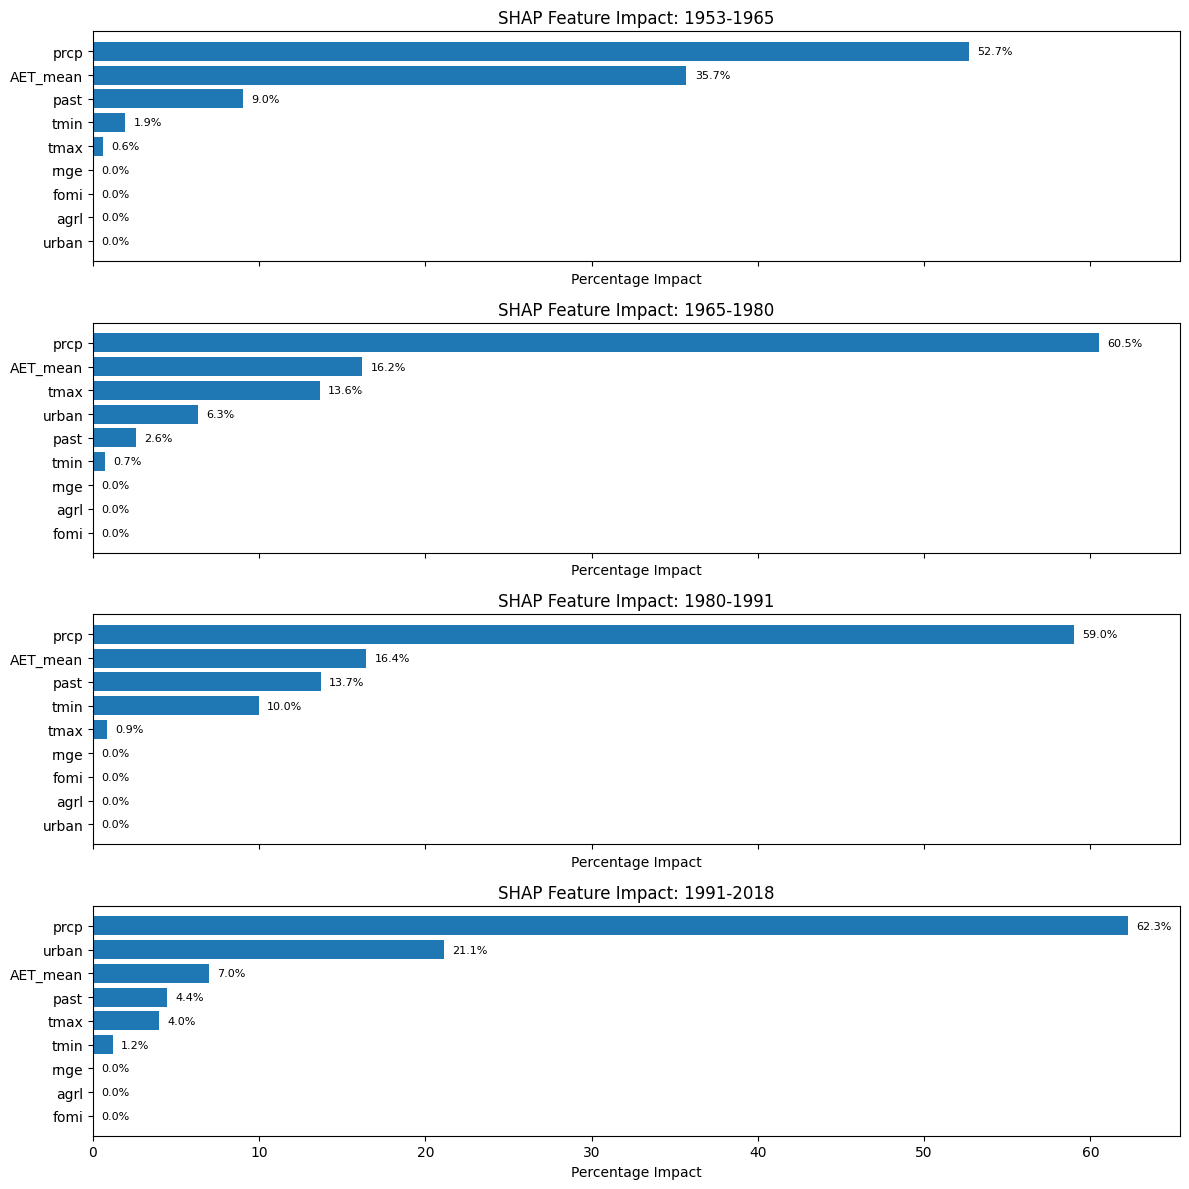

In [34]:
df = df.copy()
print(turning_points)
target = 'cumec'
features = [col for col in df.columns if col not in ['year', target, 'Baseflow(cumec)']]
group_map = {
    "urban": ["urban_precip", "urbn", "urban_tmin"]
}

# Best model params
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

intervals = intervals

# Function to compute percentage impact
def get_percentage_impact(shap_vals, columns, group_map):
    df_shap = pd.DataFrame(shap_vals, columns=columns)
    grouped_shap = {}

    for group_name, feature_list in group_map.items():
        grouped_shap[group_name] = df_shap[feature_list].abs().sum(axis=1)

    for col in columns:
        if not any(col in v for v in group_map.values()):
            grouped_shap[col] = df_shap[col].abs()

    grouped_df = pd.DataFrame(grouped_shap)
    mean_abs = grouped_df.mean()
    pct = 100 * mean_abs / mean_abs.sum()
    return pct.sort_values()

# Store all results
interval_importances = {}

for start, end in intervals:
    print(f" Processing interval: {start} to {end}")

    df_interval = df[(df['year'] >= start) & (df['year'] < end)]
    X = df_interval[features].copy()
    y = df_interval[target]
    bool_cols = X.select_dtypes(include='bool').columns
    X[bool_cols] = X[bool_cols].astype(int)

    model = xgb.XGBRegressor(**best_params, random_state=42)
    model.fit(X, y)

    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # SHAP values array
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values

    impact = get_percentage_impact(shap_vals, features, group_map)
    interval_importances[f"{start}-{end}"] = impact

# =======================
# Plot All Intervals
# =======================
fig, axes = plt.subplots(nrows=len(interval_importances), figsize=(12, len(interval_importances)*3), sharex=True)

for ax, (interval, imp) in zip(axes, interval_importances.items()):
    ax.barh(imp.index, imp.values)
    ax.set_title(f"SHAP Feature Impact: {interval}")
    ax.set_xlabel("Percentage Impact")
    for i, v in enumerate(imp.values):
        ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show();


## Monthly analysis

In [35]:
# ======Data Cleaning ======
aet_df['date'] = pd.to_datetime(aet_df['date'])
streamflow_df['date'] = pd.to_datetime(streamflow_df['date'], format='%m/%d/%Y')
baseflow_df['date'] = pd.to_datetime(baseflow_df['date'], format='%m/%d/%Y')
climate_df['date'] = pd.to_datetime(climate_df['date'])

#  Extract year and month for monthly grouping
for df in [aet_df, streamflow_df, baseflow_df, climate_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

# Group by year and month
aet_monthly = aet_df.groupby(['year', 'month'])['AET_mean'].mean().reset_index()
streamflow_monthly = streamflow_df.groupby(['year', 'month'])['cumec'].mean().reset_index()
baseflow_monthly = baseflow_df.groupby(['year', 'month'])['Baseflow(cumec)'].mean().reset_index()
climate_monthly = climate_df.groupby(['year', 'month']).agg({
    'prcp': 'mean',
    'tmin': 'mean',
    'tmax': 'mean'
}).reset_index()


In [36]:
# # Find soil moisture CSVs
# soil_files = [os.path.join(base_path, f) for f in os.listdir(base_path)
#               if f.startswith("SW_ID_") and f.endswith(".csv")]

# # Process each file
# soil_dfs = []
# for i, path in enumerate(soil_files):
#     df = pd.read_csv(path)
#     df['date'] = pd.to_datetime(df['date'])
#     df['year'] = df['date'].dt.year
#     df['month'] = df['date'].dt.month
#     df_monthly = df.groupby(['year', 'month'])['soil_moisture'].mean().reset_index()
#     df_monthly.columns = ['year', 'month', f'soil_{8795+i}']
#     soil_dfs.append(df_monthly)

# # Merge and average
# soil_combined = soil_dfs[0]
# for df in soil_dfs[1:]:
#     soil_combined = soil_combined.merge(df, on=['year', 'month'], how='outer')
# soil_combined['soil_moisture_avg'] = soil_combined.iloc[:, 2:5].mean(axis=1)
# soil_monthly = soil_combined[['year', 'month', 'soil_moisture_avg']]


In [37]:
# ===== LULC =====
lulc_monthly = lulc_df.loc[lulc_df.index.repeat(12)].copy()
lulc_monthly['month'] = list(range(1, 13)) * lulc_df.shape[0]
lulc_monthly = lulc_monthly.sort_values(['year', 'month']).reset_index(drop=True)


In [38]:
df_monthly = aet_monthly \
    .merge(baseflow_monthly, on=['year', 'month']) \
    .merge(streamflow_monthly, on=['year', 'month']) \
    .merge(climate_monthly, on=['year', 'month']) \
    .merge(lulc_monthly, on=['year', 'month'])

df_monthly = df_monthly.dropna()

df_monthly = aet_monthly \
    .merge(baseflow_monthly, on=['year', 'month']) \
    .merge(streamflow_monthly, on=['year', 'month']) \
    .merge(climate_monthly, on=['year', 'month']) \
    .merge(lulc_monthly, on=['year', 'month'])

df_monthly = df_monthly.dropna()

print(f"Shape: {df_monthly.shape}")
print('\n')
print(df_monthly.head())

Shape: (813, 17)


   year  month  AET_mean  Baseflow(cumec)      cumec      prcp       tmin  \
0  1951      1  0.428129         0.606291   2.383178  2.310876  -3.766344   
1  1951      2  0.495847        10.064965  40.808554  7.236639  -0.242823   
2  1951      3  1.275006         3.170416  12.257521  1.495831   1.974544   
3  1951      4  1.914691         2.040945   8.211872  2.737274   7.037493   
4  1951      5  2.838098         1.565254   6.160274  1.771731  11.687377   

        tmax  urbn  agrl    past    fomi  rngb  rnge  wehb    wetn    bsvg  
0   9.531410   0.0   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015  
1  12.093389   0.0   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015  
2  15.617284   0.0   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015  
3  19.196974   0.0   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015  
4  25.878853   0.0   0.0  0.6275  0.3667   0.0   0.0   0.0  0.0044  0.0015  


In [39]:
print(df_monthly.isnull().sum())
print('\n')
print(df_monthly.info())

year               0
month              0
AET_mean           0
Baseflow(cumec)    0
cumec              0
prcp               0
tmin               0
tmax               0
urbn               0
agrl               0
past               0
fomi               0
rngb               0
rnge               0
wehb               0
wetn               0
bsvg               0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             813 non-null    int32  
 1   month            813 non-null    int32  
 2   AET_mean         813 non-null    float64
 3   Baseflow(cumec)  813 non-null    float64
 4   cumec            813 non-null    float64
 5   prcp             813 non-null    float64
 6   tmin             813 non-null    float64
 7   tmax             813 non-null    float64
 8   urbn             813 non-null    float64
 9   agrl        

In [40]:
print(df_monthly.describe())

              year       month    AET_mean  Baseflow(cumec)       cumec  \
count   813.000000  813.000000  813.000000       813.000000  813.000000   
mean   1984.376384    6.483395    2.147423         2.323613    9.296323   
std      19.570034    3.449321    1.537159         2.883767   11.588467   
min    1951.000000    1.000000    0.000000         0.013894    0.055537   
25%    1967.000000    3.000000    0.697392         0.430142    1.727325   
50%    1984.000000    6.000000    1.708855         1.176062    4.732925   
75%    2001.000000    9.000000    3.417036         3.200227   12.766310   
max    2018.000000   12.000000    6.268131        22.755780   91.744605   

             prcp        tmin        tmax        urbn   agrl        past  \
count  813.000000  813.000000  813.000000  813.000000  813.0  813.000000   
mean     3.195971    8.293509   20.942972    0.005493    0.0    0.624249   
std      1.993222    8.428979    8.681097    0.005580    0.0    0.033019   
min      0.000000  -

In [41]:
df_monthly.drop(columns=['rngb', 'wehb', 'bsvg','wetn'], axis=1, inplace=True)

In [42]:
df_monthly.head()

year  month  AET_mean  Baseflow(cumec)      cumec      prcp       tmin  \
0  1951      1  0.428129         0.606291   2.383178  2.310876  -3.766344   
1  1951      2  0.495847        10.064965  40.808554  7.236639  -0.242823   
2  1951      3  1.275006         3.170416  12.257521  1.495831   1.974544   
3  1951      4  1.914691         2.040945   8.211872  2.737274   7.037493   
4  1951      5  2.838098         1.565254   6.160274  1.771731  11.687377   

        tmax  urbn  agrl    past    fomi  rnge  
0   9.531410   0.0   0.0  0.6275  0.3667   0.0  
1  12.093389   0.0   0.0  0.6275  0.3667   0.0  
2  15.617284   0.0   0.0  0.6275  0.3667   0.0  
3  19.196974   0.0   0.0  0.6275  0.3667   0.0  
4  25.878853   0.0   0.0  0.6275  0.3667   0.0

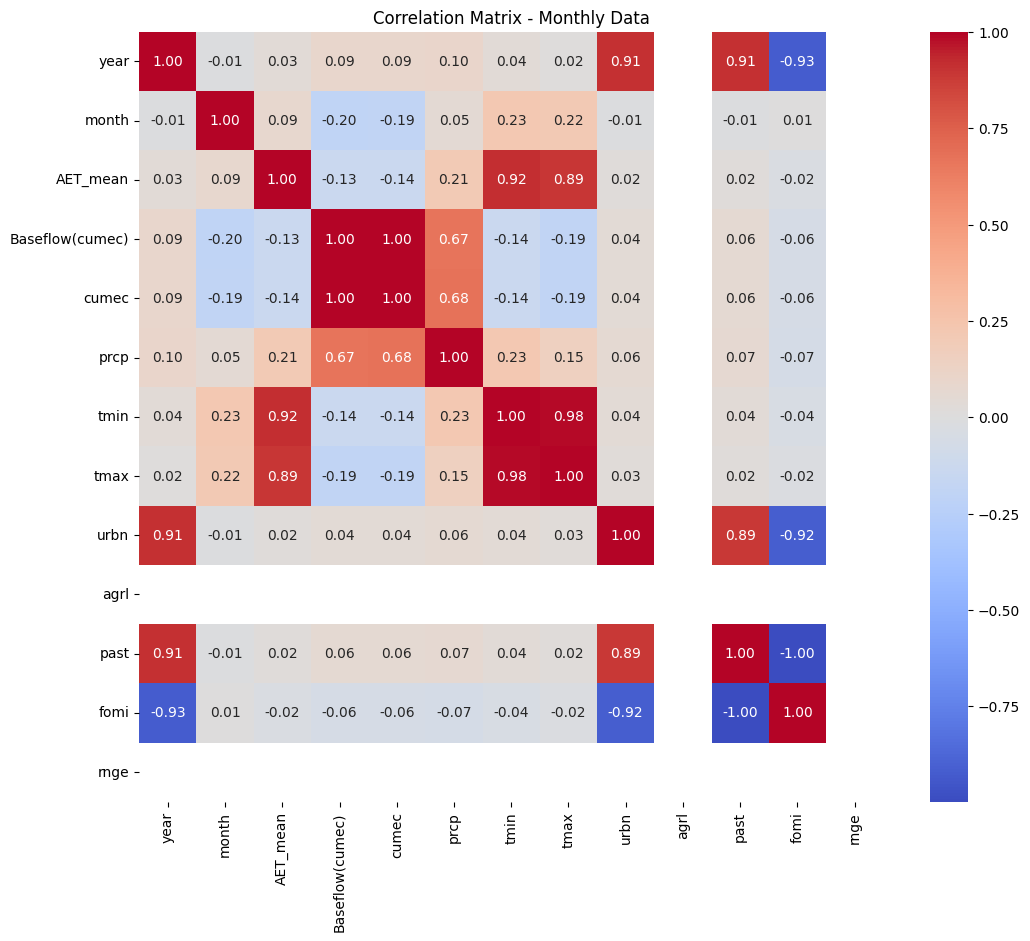

In [43]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_monthly.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix - Monthly Data")
plt.show()

In [44]:
11%12

11

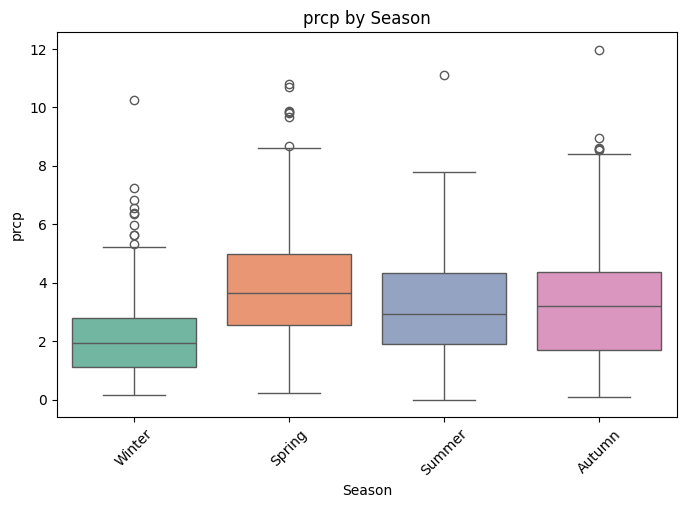

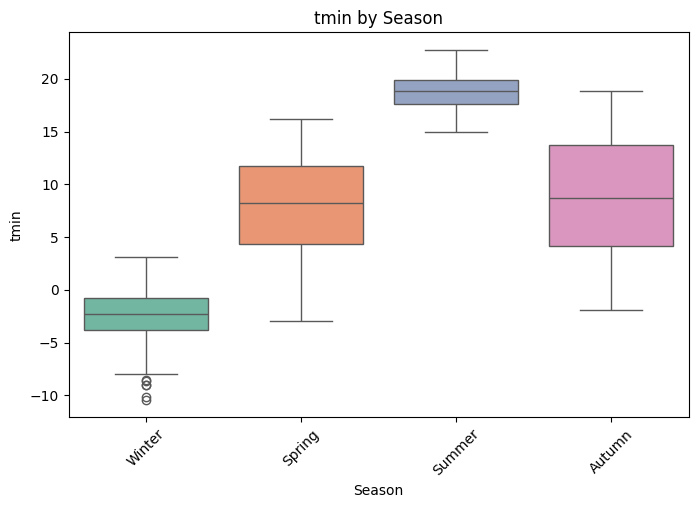

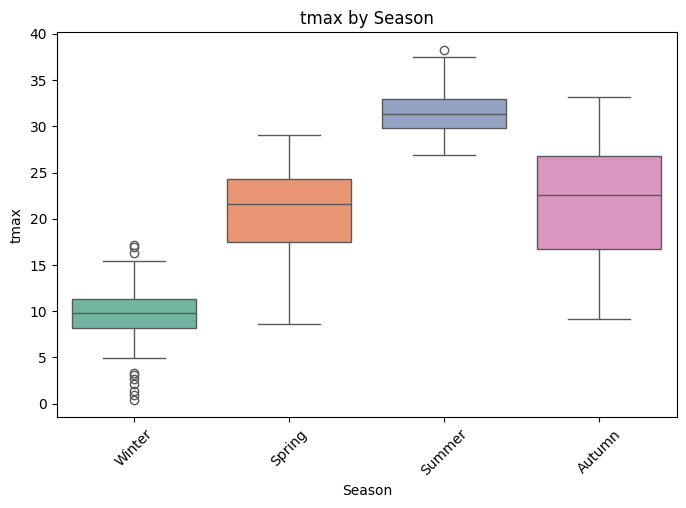

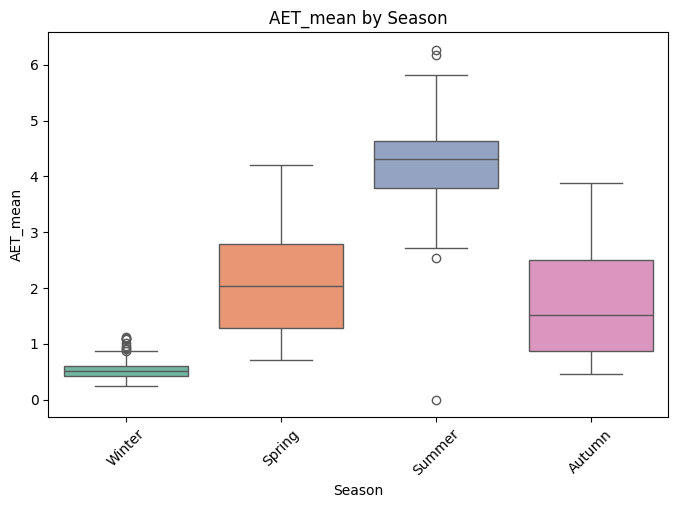

In [45]:
# Seasonal trend analysis
season_labels = ['Winter', 'Spring', 'Summer', 'Autumn']
df_monthly['season'] = df_monthly['month'] % 12 // 3 + 1
df_monthly['season'] = df_monthly['season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'})

variables = ['prcp', 'tmin', 'tmax', 'AET_mean']

for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='season', y=var, data=df_monthly, palette='Set2')
    plt.xticks(rotation=45)
    plt.title(f'{var} by Season')
    plt.xlabel('Season')
    plt.ylabel(var)
    plt.show();

In [46]:
print(df_monthly['season'].value_counts())

season
Spring    204
Summer    204
Winter    203
Autumn    202
Name: count, dtype: int64


- Precipitation:
  - Winter has lowest Precipitation
  - Summer and Autumn have high values
  - Interpretation - Most rainfall occurs in Summer

- TMin:
  - Winter has the lowest Tmin, Summer has the highest Tmax
- TMax:
   - Summer shows the highest tmax (tight spread, consistent heat).
   - Winter has the lowest.

- AET:
   - Summer leads with the highest evapotranspiration due to more heat and possibly moisture.
   - Winter has very low AET, tightly packed (low variability).
- Soil Moisture:
  - Spring has the highest median soil moisture, possibly due to snowmelt or early rains.
  - Summer shows a drop, possibly due to high evapotranspiration.
  - Winter and Autumn have moderate levels.

## One hot encoding

In [47]:
# from sklearn.preprocessing import LabelEncoder

# df_monthly = df_monthly.copy()
# label_encoder = LabelEncoder()

# df_monthly['Season'] = label_encoder.fit_transform(df_monthly['season'])

# Apply One-Hot Encoding
df_monthly = pd.get_dummies(df_monthly, columns=['season'])

In [48]:
df_monthly

year  month  AET_mean  Baseflow(cumec)      cumec      prcp       tmin  \
0    1951      1  0.428129         0.606291   2.383178  2.310876  -3.766344   
1    1951      2  0.495847        10.064965  40.808554  7.236639  -0.242823   
2    1951      3  1.275006         3.170416  12.257521  1.495831   1.974544   
3    1951      4  1.914691         2.040945   8.211872  2.737274   7.037493   
4    1951      5  2.838098         1.565254   6.160274  1.771731  11.687377   
..    ...    ...       ...              ...        ...       ...        ...   
808  2018      5  4.082064         4.661900  18.525581  4.064893  16.156794   
809  2018      6  3.938463         0.639809   2.491690  2.032225  19.577441   
810  2018      7  4.525149         0.376376   1.495218  3.291224  20.417809   
811  2018      8  4.382000         0.567460   2.270825  5.043940  19.637525   
812  2018      9  2.871606         0.277816   1.098126  2.121297  17.611743   

          tmax    urbn  agrl    past    fomi  rnge  season_Autumn  \
0     9.531410  0.0000   0.0  0.6275  0.3667   0.0          False   
1    12.093389  0.0000   0.0  0.6275  0.3667   0.0          False   
2    15.617284  0.0000   0.0  0.6275  0.3667   0.0          False   
3    19.196974  0.0000   0.0  0.6275  0.3667   0.0          False   
4    25.878853  0.0000   0.0  0.6275  0.3667   0.0          False   
..         ...     ...   ...     ...     ...   ...            ...   
808  29.104317  0.0178   0.0  0.6753  0.3011   0.0          False   
809  31.575258  0.0178   0.0  0.6753  0.3011   0.0          False   
810  33.376173  0.0178   0.0  0.6753  0.3011   0.0          False   
811  30.418999  0.0178   0.0  0.6753  0.3011   0.0          False   
812  28.460849  0.0178   0.0  0.6753  0.3011   0.0           True   

     season_Spring  season_Summer  season_Winter  
0            False          False           True  
1            False          False           True  
2             True          False          False  
3             True          False          False  
4             True          False          False  
..             ...            ...            ...  
808           True          False          False  
809          False           True          False  
810          False           True          False  
811          False           True          False  
812          False          False          False  

[813 rows x 17 columns]

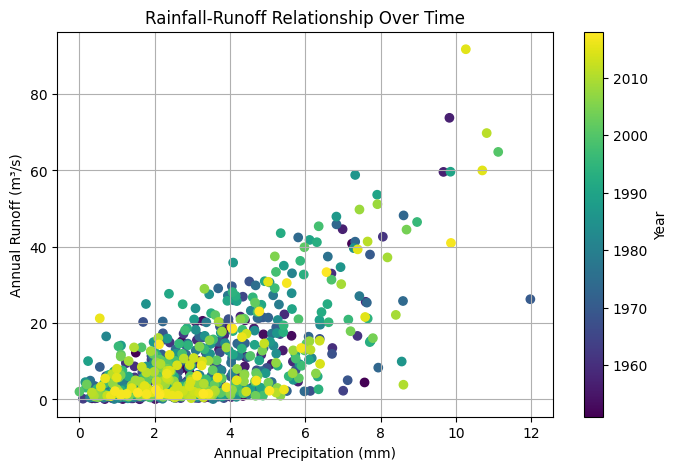

In [49]:
#Plot rainfall-runoff relationship over time
plt.figure(figsize=(8, 5))
plt.scatter(df_monthly['prcp'], df_monthly['cumec'], c=df_monthly['year'], cmap='viridis')
plt.xlabel("Annual Precipitation (mm)")
plt.ylabel("Annual Runoff (m³/s)")
plt.title("Rainfall-Runoff Relationship Over Time")
plt.colorbar(label='Year')
plt.grid(True)
plt.show()

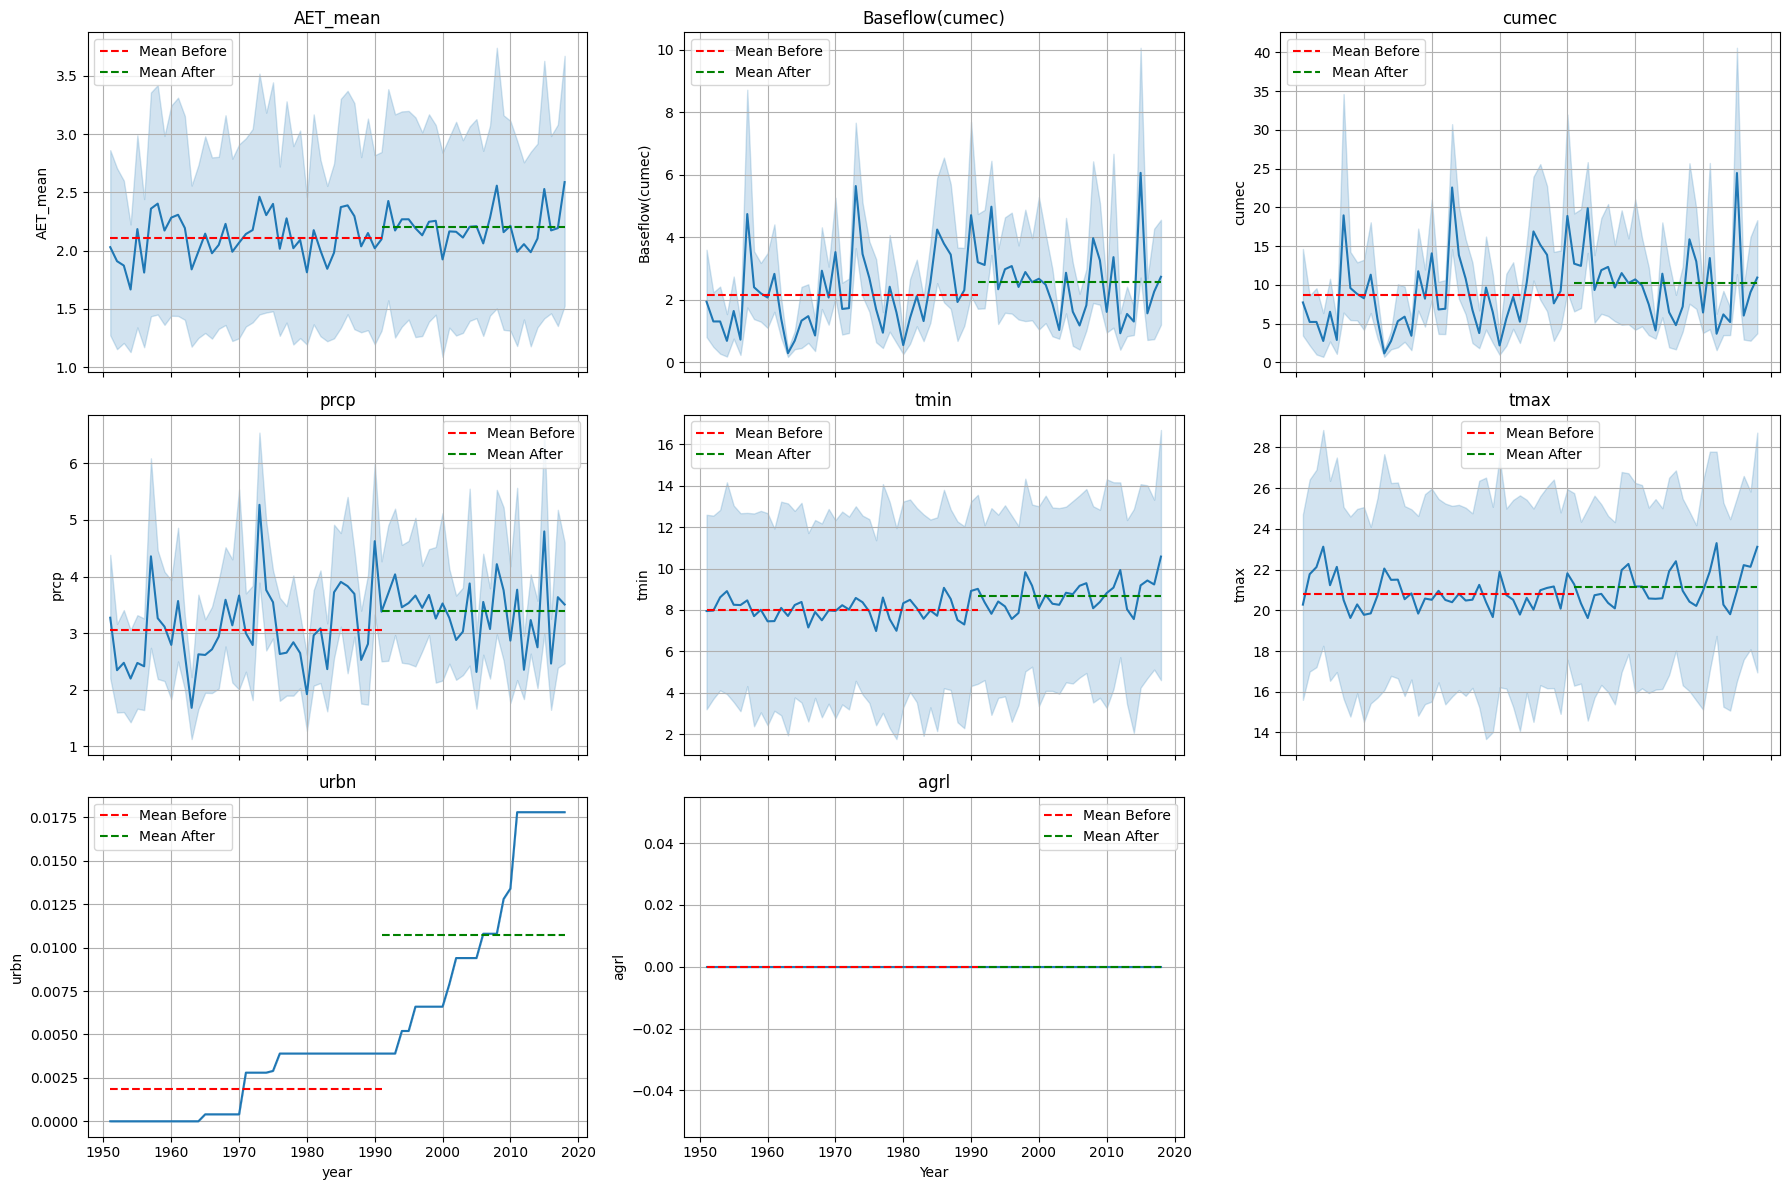

In [50]:
features = ['AET_mean','Baseflow(cumec)','cumec','prcp','tmin','tmax',
            'urbn','agrl']
change_point = 1991

n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Plot line
    sns.lineplot(x=df_monthly['year'], y=df_monthly[feature], ax=ax)

    # Mean before/after change point
    mean_before = df_monthly[df_monthly['year'] < change_point][feature].mean()
    mean_after = df_monthly[df_monthly['year'] >= change_point][feature].mean()

    # Horizontal mean lines
    ax.hlines(mean_before, xmin=df_monthly['year'].min(), xmax=change_point, colors='red', linestyles='dashed', label='Mean Before')
    ax.hlines(mean_after, xmin=change_point, xmax=df_monthly['year'].max(), colors='green', linestyles='dashed', label='Mean After')

    ax.set_title(f"{feature}")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend()

# Remove unused subplots if features < total grid size
for j in range(i + 1, len(axes)):
     fig.delaxes(axes[j])
plt.xlabel("Year")
plt.tight_layout()
plt.show()


In [51]:
df_monthly.head()

year  month  AET_mean  Baseflow(cumec)      cumec      prcp       tmin  \
0  1951      1  0.428129         0.606291   2.383178  2.310876  -3.766344   
1  1951      2  0.495847        10.064965  40.808554  7.236639  -0.242823   
2  1951      3  1.275006         3.170416  12.257521  1.495831   1.974544   
3  1951      4  1.914691         2.040945   8.211872  2.737274   7.037493   
4  1951      5  2.838098         1.565254   6.160274  1.771731  11.687377   

        tmax  urbn  agrl    past    fomi  rnge  season_Autumn  season_Spring  \
0   9.531410   0.0   0.0  0.6275  0.3667   0.0          False          False   
1  12.093389   0.0   0.0  0.6275  0.3667   0.0          False          False   
2  15.617284   0.0   0.0  0.6275  0.3667   0.0          False           True   
3  19.196974   0.0   0.0  0.6275  0.3667   0.0          False           True   
4  25.878853   0.0   0.0  0.6275  0.3667   0.0          False           True   

   season_Summer  season_Winter  
0          False           True  
1          False           True  
2          False          False  
3          False          False  
4          False          False

In [52]:
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

for season in seasons:
    season_df = df_monthly[df_monthly['season_' + season] == 1]
    if not season_df.empty:
        data_array = season_df[['year', 'cumec']].to_numpy()
        result = seq_mk(data_array)
        change_years = result[result['turning_point'] == 1]['year'].values
        print(f"{season} - Change years:", change_years)


Winter - Change years: [1956. 1957. 1964. 1969. 1980. 1991.]
Spring - Change years: [1952. 1956. 1957. 1964. 1974. 1981. 1987. 2007. 2008. 2017. 2018.]
Summer - Change years: [1952. 1953. 1953. 1957. 1967. 1969. 1969. 1970. 1970. 1973. 1980. 1981.
 1984. 1986. 1988. 1993. 2014. 2015.]
Autumn - Change years: [1956. 1957. 1983. 1986.]


In [53]:
# SMK TEST
# Exclude first and last 5 years
min_year = df_monthly['year'].min() + 5
max_year = df_monthly['year'].max() - 5
filtered_df = df_monthly[(df_monthly['year'] >= min_year) & (df_monthly['year'] <= max_year)]

# Select year and cumec for SMK
data_array = filtered_df[['year', 'cumec']].to_numpy()

# Run Sequential Mann-Kendall test
result = seq_mk(data_array)

# View detected change years
turning_points = result[result['turning_point'] == 1]['year'].drop_duplicates().sort_values().astype(int).tolist()
print("Non-stationary turning point years:", turning_points)


Non-stationary turning point years: [1956, 1957, 1963, 1973, 1979, 1993, 2006, 2008, 2009]


In [54]:
print(change_years)

[1956. 1957. 1983. 1986.]


In [55]:
df_monthly.to_csv("df_monthly.csv", index=False)

In [56]:
df_monthly.head()

year  month  AET_mean  Baseflow(cumec)      cumec      prcp       tmin  \
0  1951      1  0.428129         0.606291   2.383178  2.310876  -3.766344   
1  1951      2  0.495847        10.064965  40.808554  7.236639  -0.242823   
2  1951      3  1.275006         3.170416  12.257521  1.495831   1.974544   
3  1951      4  1.914691         2.040945   8.211872  2.737274   7.037493   
4  1951      5  2.838098         1.565254   6.160274  1.771731  11.687377   

        tmax  urbn  agrl    past    fomi  rnge  season_Autumn  season_Spring  \
0   9.531410   0.0   0.0  0.6275  0.3667   0.0          False          False   
1  12.093389   0.0   0.0  0.6275  0.3667   0.0          False          False   
2  15.617284   0.0   0.0  0.6275  0.3667   0.0          False           True   
3  19.196974   0.0   0.0  0.6275  0.3667   0.0          False           True   
4  25.878853   0.0   0.0  0.6275  0.3667   0.0          False           True   

   season_Summer  season_Winter  
0          False           True  
1          False           True  
2          False          False  
3          False          False  
4          False          False

In [57]:
# Dataset bounds
start_year = 1953
end_year = 2018
min_interval_gap = 10  # minimum gap in years

# Step 1: Filter turning points with ~10-year separation
filtered_tp = []
last_added = 1953
for year in turning_points:
    if last_added is None or (year - last_added >= min_interval_gap):
        filtered_tp.append(year)
        last_added = year

# Step 2: Add start_year if far enough from first filtered_tp
if filtered_tp and (filtered_tp[0] - start_year >= min_interval_gap):
    filtered_tp = [start_year] + filtered_tp

# Step 3: Add end_year if needed
if filtered_tp[-1] < end_year:
    filtered_tp.append(end_year)

# Step 4: Form intervals
intervals = [(filtered_tp[i], filtered_tp[i + 1]) for i in range(len(filtered_tp) - 1)]

# Output
print("Filtered Turning Points:", filtered_tp)
print("Intervals:", intervals)

Filtered Turning Points: [1953, 1963, 1973, 1993, 2006, 2018]
Intervals: [(1953, 1963), (1963, 1973), (1973, 1993), (1993, 2006), (2006, 2018)]


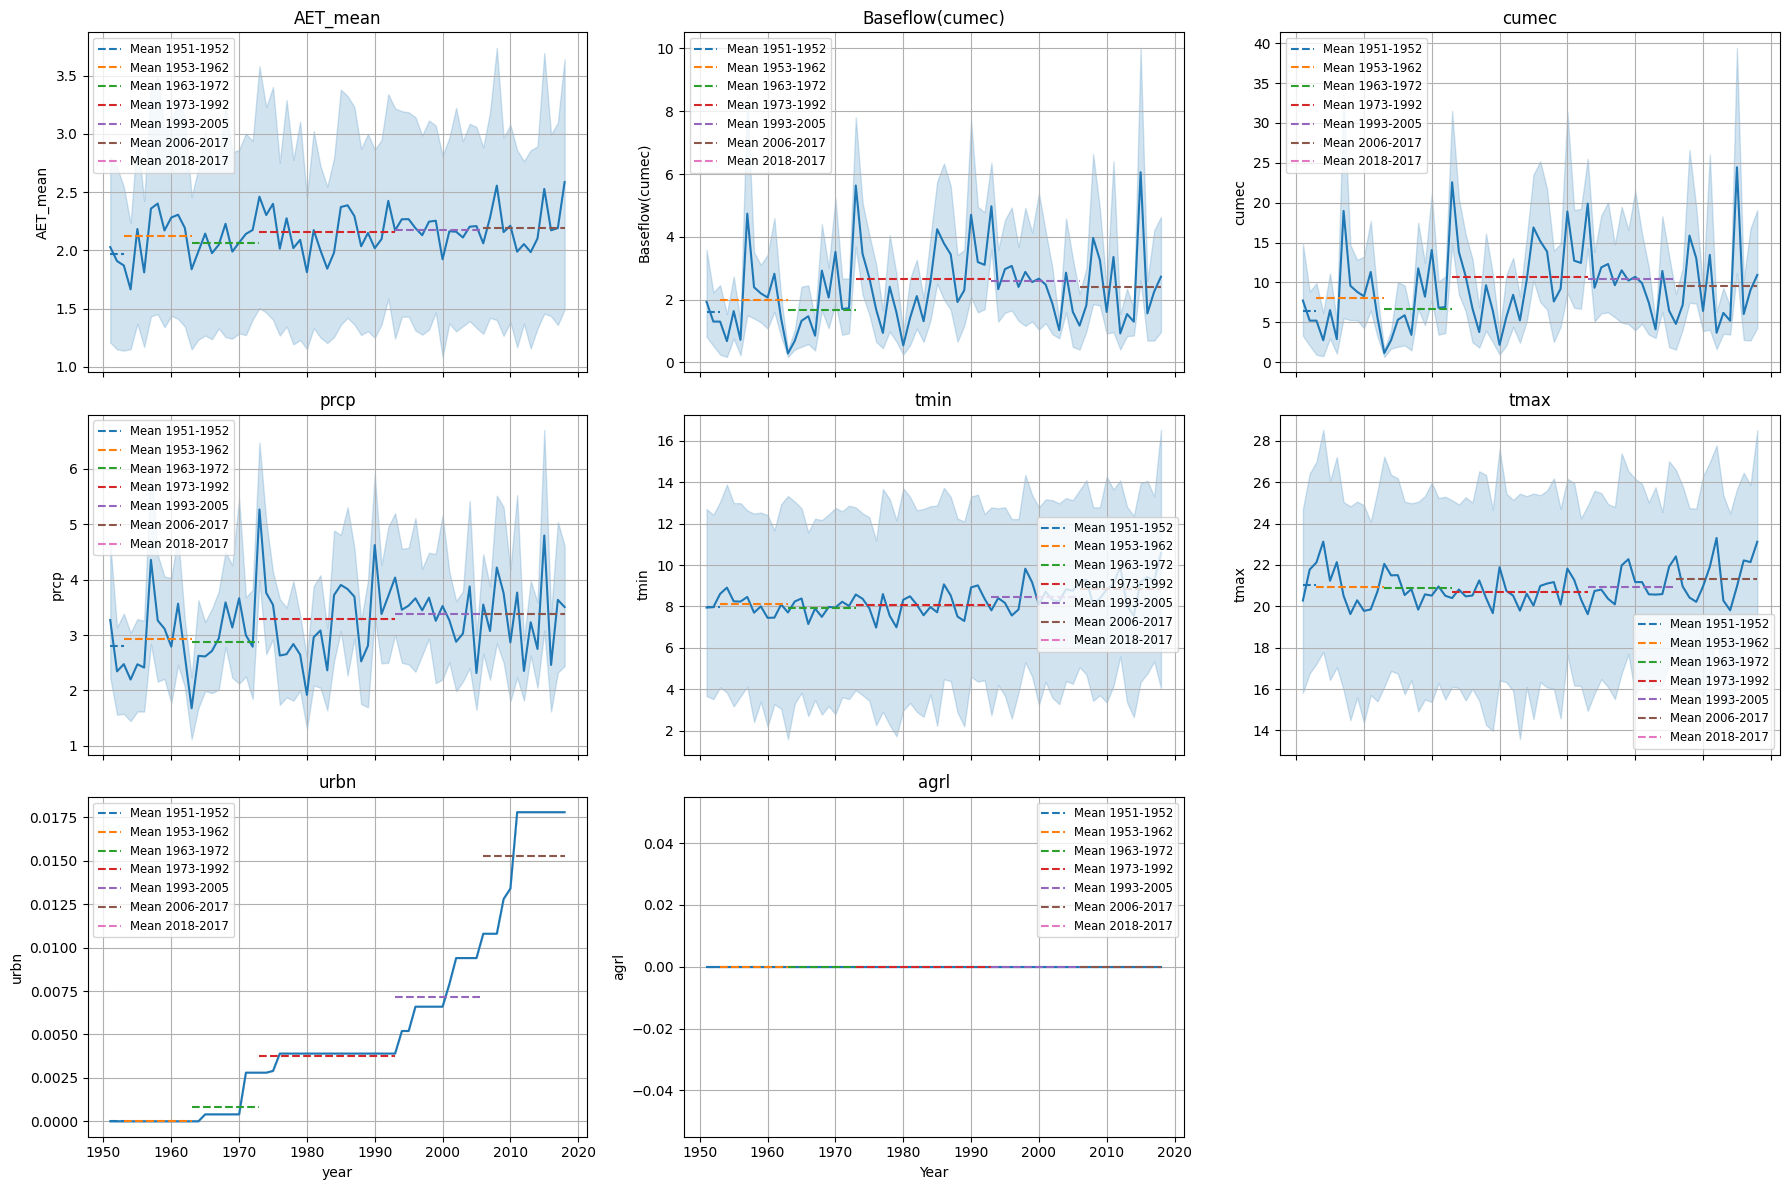

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

features = ['AET_mean', 'Baseflow(cumec)', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl']
change_points = filtered_tp
all_years = [df_monthly['year'].min()] + change_points + [df_monthly['year'].max()]

n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Plot time series
    sns.lineplot(x=df_monthly['year'], y=df_monthly[feature], ax=ax)

    # Plot means between change points
    for j in range(len(all_years) - 1):
        start_year = all_years[j]
        end_year = all_years[j + 1]

        mask = (df_monthly['year'] >= start_year) & (df_monthly['year'] < end_year)
        mean_val = df_monthly.loc[mask, feature].mean()

        ax.hlines(mean_val, xmin=start_year, xmax=end_year,
                  colors='C'+str(j), linestyles='dashed',
                  label=f'Mean {start_year}-{end_year-1}')

    ax.set_title(f"{feature}")
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(fontsize='small')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.xlabel("Year")
plt.tight_layout()
plt.show()

<ipython-input-59-ccf94914b203>:66: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


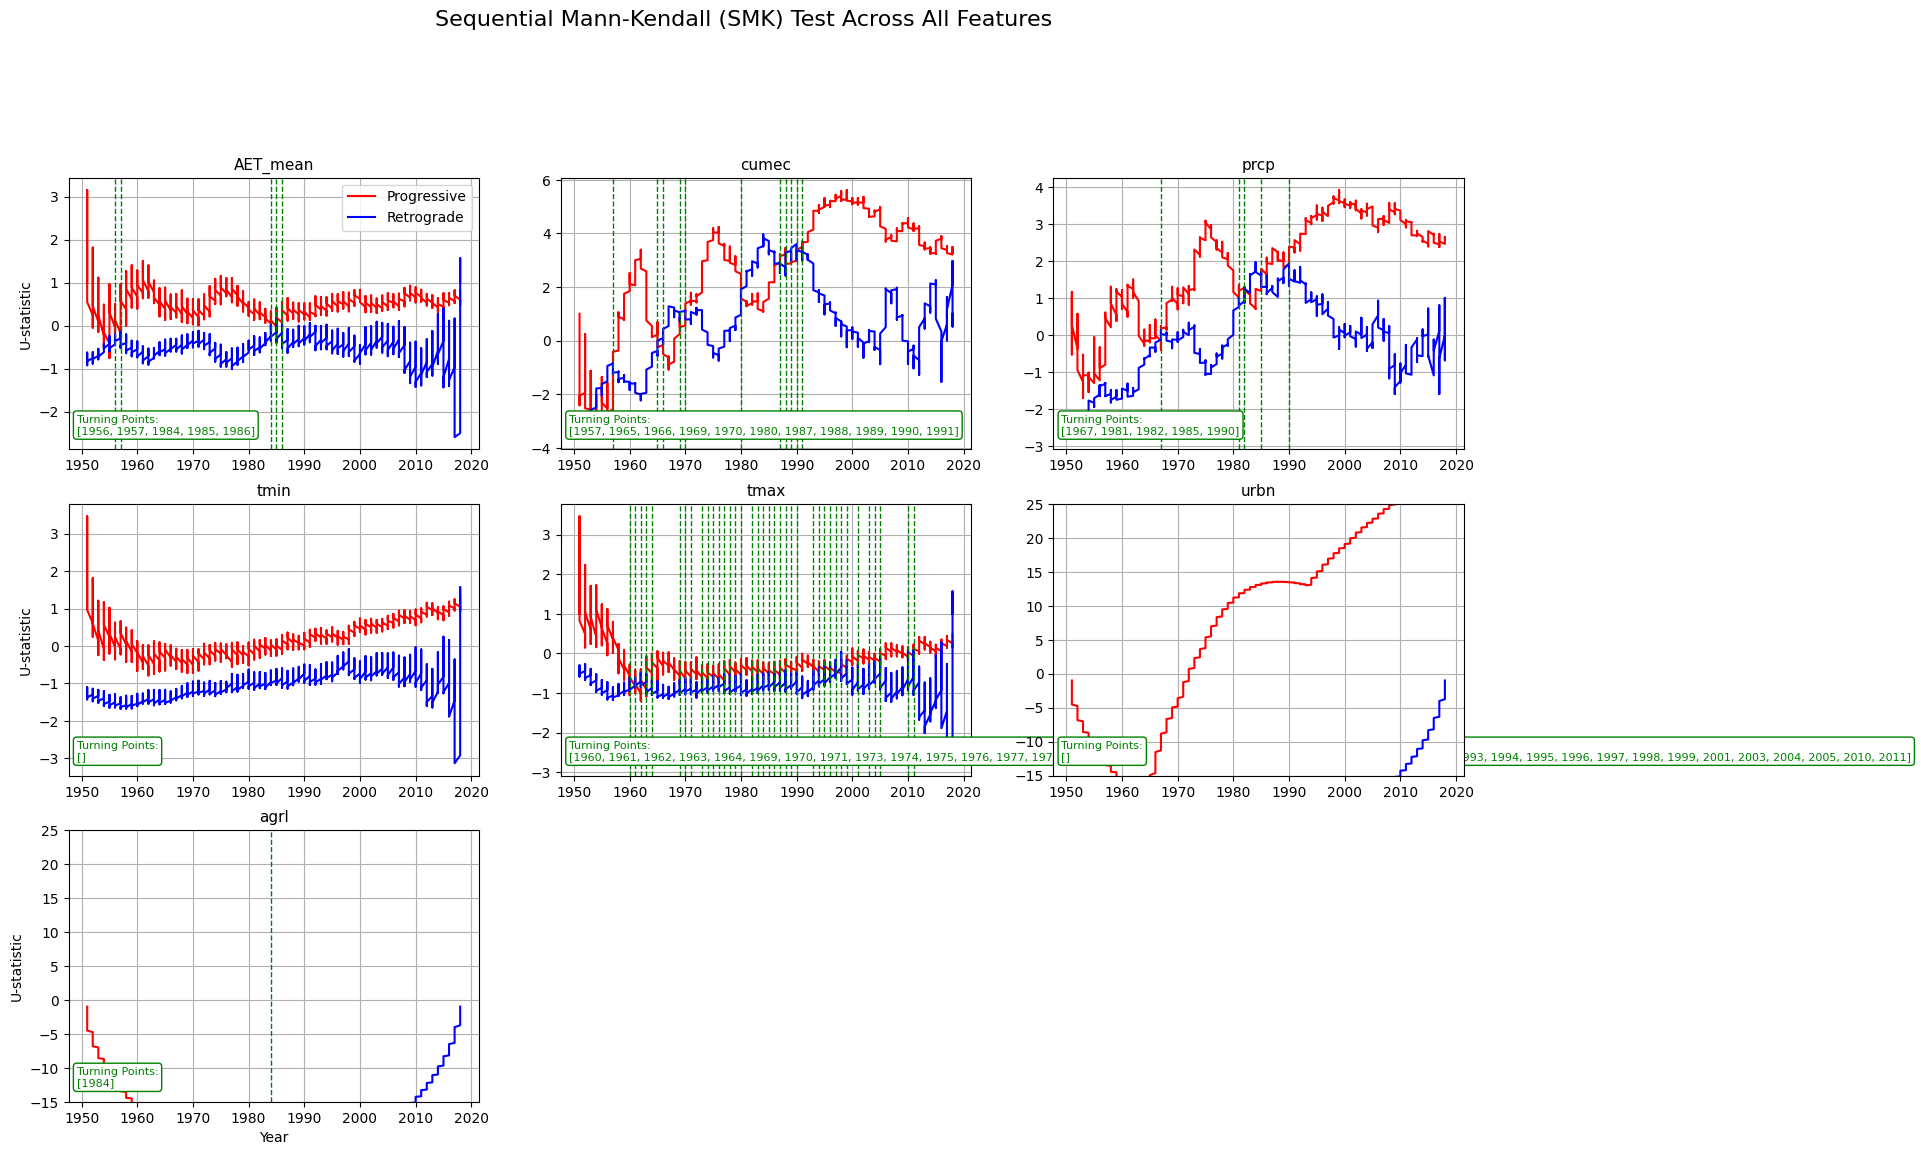

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import math

df_monthly = pd.read_csv("df_monthly.csv")

features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax',
             'urbn', 'agrl']

cols = 3
rows = math.ceil(len(features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    data_array = df_monthly[['year', feature]].to_numpy()
    result = seq_mk(data_array)

    year = result['year']
    u_prog = result['u_prog']
    u_retr = result['u_retr']

    # Determine first and last 5 years to exclude
    min_year, max_year = year.min(), year.max()
    exclude_range = 4
    valid_turning = sorted(set(
    result[
        (result['turning_point'] == 1) &
        (result['year'] > min_year + exclude_range) &
        (result['year'] < max_year - exclude_range)
    ]['year'].astype(int)
))

    # Plot lines
    ax.plot(year, u_prog, 'r', label='Progressive')
    ax.plot(year, u_retr, 'b', label='Retrograde')

    # Plot turning points
    for ty in valid_turning:
        ax.axvline(ty, color='green', linestyle='--', linewidth=1)
    # Add turning point list as text
    tp_text = f"Turning Points:\n{valid_turning}"
    ax.text(0.02, 0.05, tp_text,
            transform=ax.transAxes,
            fontsize=8, color='green',
            verticalalignment='bottom',
            bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

    # Rescale y-axis for extreme cases
    if feature in ['urbn', 'agrl']:
        ax.set_ylim(-15, 25)  # tweak as needed

    ax.set_title(f"{feature}", fontsize=11)
    ax.grid(True)

    if idx % cols == 0:
        ax.set_ylabel("U-statistic")
    if idx >= (rows - 1) * cols:
        ax.set_xlabel("Year")

# Delete unused axes
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.suptitle("Sequential Mann-Kendall (SMK) Test Across All Features", fontsize=16, y=1.02)
axes[0].legend(loc='upper right')
plt.show()

In [60]:
df_monthly['urban_precip'] = df_monthly['urbn'] * df_monthly['prcp']
df_monthly['urban_tmin'] = df_monthly['urbn'] * df_monthly['tmin']

In [61]:
df_monthly.head()

year  month  AET_mean  Baseflow(cumec)      cumec      prcp       tmin  \
0  1951      1  0.428129         0.606291   2.383178  2.310876  -3.766344   
1  1951      2  0.495847        10.064965  40.808554  7.236639  -0.242823   
2  1951      3  1.275006         3.170416  12.257521  1.495831   1.974544   
3  1951      4  1.914691         2.040945   8.211872  2.737274   7.037493   
4  1951      5  2.838098         1.565254   6.160274  1.771731  11.687377   

        tmax  urbn  agrl    past    fomi  rnge  season_Autumn  season_Spring  \
0   9.531410   0.0   0.0  0.6275  0.3667   0.0          False          False   
1  12.093389   0.0   0.0  0.6275  0.3667   0.0          False          False   
2  15.617284   0.0   0.0  0.6275  0.3667   0.0          False           True   
3  19.196974   0.0   0.0  0.6275  0.3667   0.0          False           True   
4  25.878853   0.0   0.0  0.6275  0.3667   0.0          False           True   

   season_Summer  season_Winter  urban_precip  urban_tmin  
0          False           True           0.0        -0.0  
1          False           True           0.0        -0.0  
2          False          False           0.0         0.0  
3          False          False           0.0         0.0  
4          False          False           0.0         0.0

In [62]:
intervals

[(1953, 1963), (1963, 1973), (1973, 1993), (1993, 2006), (2006, 2018)]

[1956, 1957, 1963, 1973, 1979, 1993, 2006, 2008, 2009]
 Processing interval: 1953 to 1963
 Processing interval: 1963 to 1973
 Processing interval: 1973 to 1993
 Processing interval: 1993 to 2006
 Processing interval: 2006 to 2018


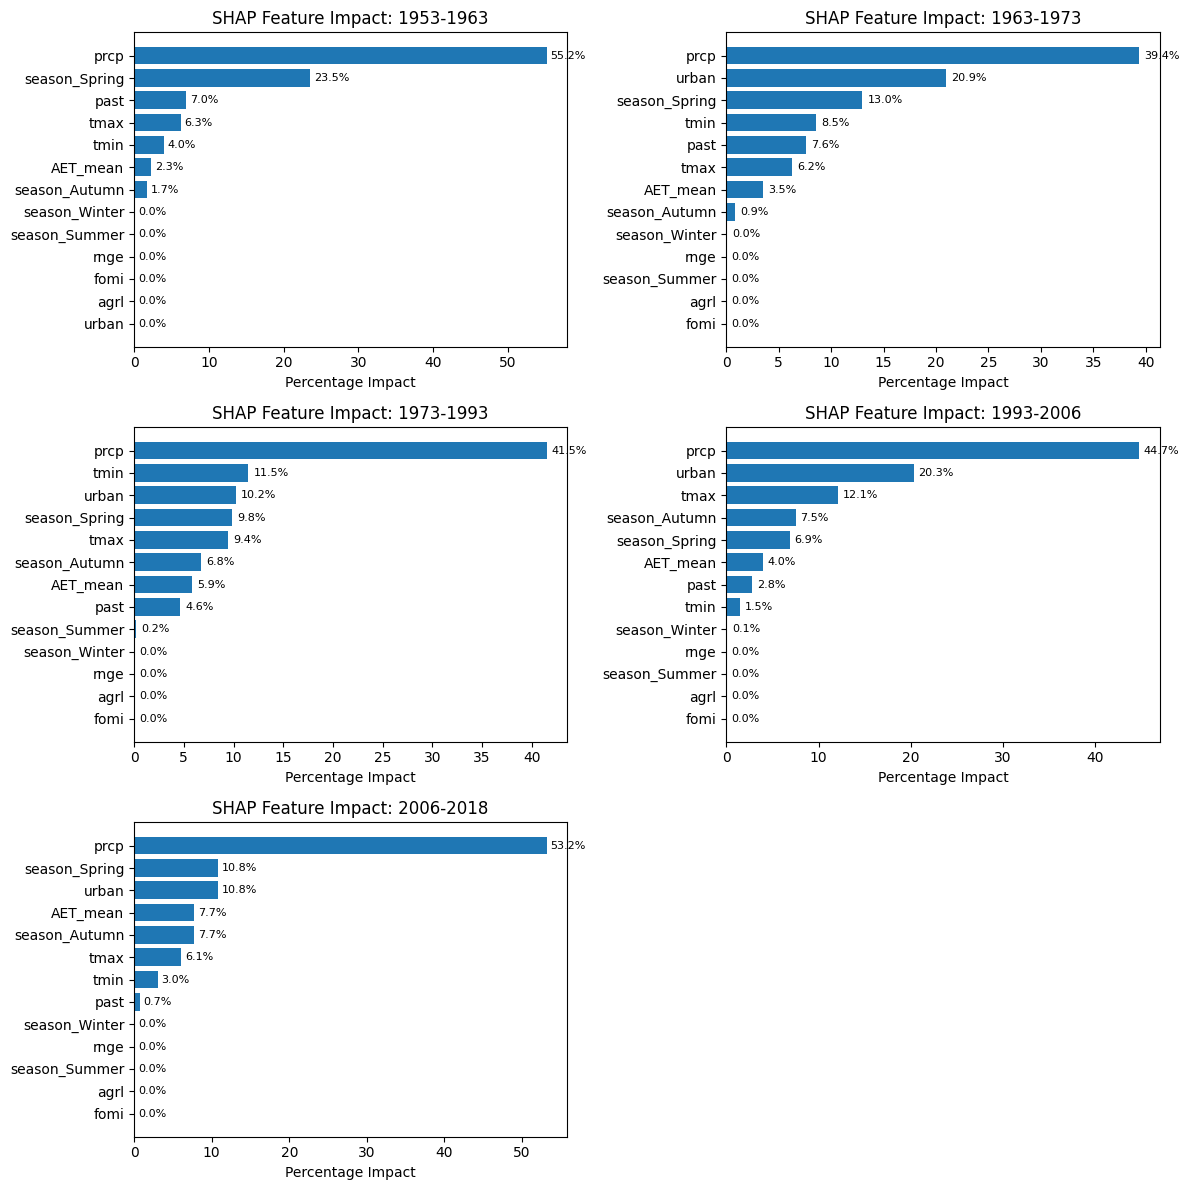

In [63]:
df_monthly = df_monthly.copy()
print(turning_points)
target = 'cumec'
features = [col for col in df_monthly.columns if col not in ['year', target, 'Baseflow(cumec)', 'month']]
group_map = {
    "urban": ["urban_precip", "urbn", "urban_tmin"]
}

# Best model params
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

intervals = intervals

# Function to compute percentage impact
def get_percentage_impact(shap_vals, columns, group_map):
    df_shap = pd.DataFrame(shap_vals, columns=columns)
    grouped_shap = {}

    for group_name, feature_list in group_map.items():
        grouped_shap[group_name] = df_shap[feature_list].abs().sum(axis=1)

    for col in columns:
        if not any(col in v for v in group_map.values()):
            grouped_shap[col] = df_shap[col].abs()

    grouped_df = pd.DataFrame(grouped_shap)
    mean_abs = grouped_df.mean()
    pct = 100 * mean_abs / mean_abs.sum()
    return pct.sort_values()

# Store all results
interval_importances = {}

for start, end in intervals:
    print(f" Processing interval: {start} to {end}")

    df_interval = df_monthly[(df_monthly['year'] >= start) & (df_monthly['year'] < end)]
    X = df_interval[features].copy()
    y = df_interval[target]
    bool_cols = X.select_dtypes(include='bool').columns
    X[bool_cols] = X[bool_cols].astype(int)

    model = xgb.XGBRegressor(**best_params, random_state=42)
    model.fit(X, y)

    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

    # SHAP values array
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values

    impact = get_percentage_impact(shap_vals, features, group_map)
    interval_importances[f"{start}-{end}"] = impact

# =======================
# Plot All Intervals
# =======================
n_intervals = len(interval_importances)
n_cols = 2
n_rows = math.ceil(n_intervals / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=False)
axes = axes.flatten()

for ax, (interval, imp) in zip(axes, interval_importances.items()):
    ax.barh(imp.index, imp.values)
    ax.set_title(f"SHAP Feature Impact: {interval}")
    ax.set_xlabel("Percentage Impact")
    for i, v in enumerate(imp.values):
        ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

# Remove unused subplots if any
for i in range(len(interval_importances), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(nrows=len(interval_importances), figsize=(12, len(interval_importances)*3), sharex=True)

# for ax, (interval, imp) in zip(axes, interval_importances.items()):
#     ax.barh(imp.index, imp.values)
#     ax.set_title(f"SHAP Feature Impact: {interval}")
#     ax.set_xlabel("Percentage Impact")
#     for i, v in enumerate(imp.values):
#         ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

# plt.tight_layout()
# plt.show();


In [65]:
df_monthly.head()

year  month  AET_mean  Baseflow(cumec)      cumec      prcp       tmin  \
0  1951      1  0.428129         0.606291   2.383178  2.310876  -3.766344   
1  1951      2  0.495847        10.064965  40.808554  7.236639  -0.242823   
2  1951      3  1.275006         3.170416  12.257521  1.495831   1.974544   
3  1951      4  1.914691         2.040945   8.211872  2.737274   7.037493   
4  1951      5  2.838098         1.565254   6.160274  1.771731  11.687377   

        tmax  urbn  agrl    past    fomi  rnge  season_Autumn  season_Spring  \
0   9.531410   0.0   0.0  0.6275  0.3667   0.0          False          False   
1  12.093389   0.0   0.0  0.6275  0.3667   0.0          False          False   
2  15.617284   0.0   0.0  0.6275  0.3667   0.0          False           True   
3  19.196974   0.0   0.0  0.6275  0.3667   0.0          False           True   
4  25.878853   0.0   0.0  0.6275  0.3667   0.0          False           True   

   season_Summer  season_Winter  urban_precip  urban_tmin  
0          False           True           0.0        -0.0  
1          False           True           0.0        -0.0  
2          False          False           0.0         0.0  
3          False          False           0.0         0.0  
4          False          False           0.0         0.0

In [77]:
df_seasons = df_monthly.drop(columns=['season_Autumn','season_Spring','season_Summer','season_Winter'])
df_seasons.head()

year  month  AET_mean  Baseflow(cumec)      cumec      prcp       tmin  \
0  1951      1  0.428129         0.606291   2.383178  2.310876  -3.766344   
1  1951      2  0.495847        10.064965  40.808554  7.236639  -0.242823   
2  1951      3  1.275006         3.170416  12.257521  1.495831   1.974544   
3  1951      4  1.914691         2.040945   8.211872  2.737274   7.037493   
4  1951      5  2.838098         1.565254   6.160274  1.771731  11.687377   

        tmax  urbn  agrl    past    fomi  rnge  urban_precip  urban_tmin  
0   9.531410   0.0   0.0  0.6275  0.3667   0.0           0.0        -0.0  
1  12.093389   0.0   0.0  0.6275  0.3667   0.0           0.0        -0.0  
2  15.617284   0.0   0.0  0.6275  0.3667   0.0           0.0         0.0  
3  19.196974   0.0   0.0  0.6275  0.3667   0.0           0.0         0.0  
4  25.878853   0.0   0.0  0.6275  0.3667   0.0           0.0         0.0

In [80]:
season_months = {
    'Summer': [6, 7, 8],    # June, July, August
    'Autumn': [9, 10, 11],  # September, October, November
    'Winter': [12, 1, 2],   # December, January, February
    'Spring': [3, 4, 5]     # March, April, May
}

# A dictionary to hold seasonal data
seasonal_means = {}

for season, months in season_months.items():

    season_df = df_seasons[df_seasons['month'].isin(months)]

    season_mean = season_df.groupby('year').mean()
    seasonal_means[season] = season_mean

# Reset index to get 'year' as a column
for season in seasonal_means:
    seasonal_means[season] = seasonal_means[season].reset_index()

# Assign seasonal data
summer_data = seasonal_means['Summer']
winter_data = seasonal_means['Winter']
spring_data = seasonal_means['Spring']
fall_data = seasonal_means['Autumn']

print(summer_data.head())

   year  month  AET_mean  Baseflow(cumec)     cumec      prcp       tmin  \
0  1951    7.0  4.070649         1.050592  4.189090  4.037267  19.070734   
1  1952    7.0  3.998212         0.428086  1.656066  2.496188  19.843359   
2  1953    7.0  3.674130         0.365686  1.431978  2.169674  19.541041   
3  1954    7.0  2.921067         0.100617  0.382673  1.287595  20.440704   
4  1955    7.0  4.132617         1.764995  6.962299  2.888543  18.263795   

        tmax  urbn  agrl    past    fomi  rnge  urban_precip  urban_tmin  
0  30.352196   0.0   0.0  0.6275  0.3667   0.0           0.0         0.0  
1  33.210315   0.0   0.0  0.6054  0.3887   0.0           0.0         0.0  
2  32.733318   0.0   0.0  0.5850  0.4091   0.0           0.0         0.0  
3  35.699893   0.0   0.0  0.5926  0.4015   0.0           0.0         0.0  
4  31.112718   0.0   0.0  0.5845  0.4096   0.0           0.0         0.0  


In [96]:
summer_df = seasonal_means['Summer']
winter_df = seasonal_means['Winter']
spring_df = seasonal_means['Spring']
autumn_df = seasonal_means['Autumn']

In [113]:
def filter_significant_turning_points(df, turning_points, change_threshold=0.8, min_interval_gap=10):
    filtered_tp = []
    start_year = df['year'].min()
    end_year = df['year'].max()

    # First always include the start year
    last_added_year = start_year
    filtered_tp.append(start_year)

    for year in turning_points:
        if year < start_year or year > end_year:
            continue

        cumec_current = df.loc[df['year'] == year, 'cumec'].values[0]
        cumec_last = df.loc[df['year'] == last_added_year, 'cumec'].values[0]

        if cumec_last == 0:
            continue

        relative_change = abs(cumec_current - cumec_last) / abs(cumec_last)

        if (relative_change >= change_threshold) and (year - last_added_year >= min_interval_gap):
            filtered_tp.append(year)
            last_added_year = year

    # Always include the end year if not already included
    if filtered_tp[-1] != end_year:
        filtered_tp.append(end_year)

    return filtered_tp

In [132]:
def process_season(df_season, season_name):
    print(f"\n=== Processing Season: {season_name} ===")

    # Excluding first and last 5 years
    min_year = df_season['year'].min() + 5
    max_year = df_season['year'].max() - 5
    filtered_df = df_season[(df_season['year'] >= min_year) & (df_season['year'] <= max_year)]

    # Sequential Mann-Kendall (SMK) Test
    data_array = filtered_df[['year', 'cumec']].to_numpy()
    result = seq_mk(data_array)

    # Find turning points
    turning_points = result[result['turning_point'] == 1]['year'].drop_duplicates().sort_values().astype(int).tolist()
    print("Raw Turning Points:", turning_points)

    # Filter turning points
    start_year = df_season['year'].min()
    end_year = df_season['year'].max()

    filtered_tp = filter_significant_turning_points(df_season, turning_points, change_threshold=0.15, min_interval_gap=10)

    # Ensure start and end year included properly
    if filtered_tp[0] != start_year:
        filtered_tp = [start_year] + filtered_tp
    if filtered_tp[-1] != end_year:
        filtered_tp.append(end_year)

    # Remove duplicates if any
    filtered_tp = sorted(list(set(filtered_tp)))

    # Create intervals
    intervals = [(filtered_tp[i], filtered_tp[i+1]) for i in range(len(filtered_tp)-1)]

    #print("Filtered Turning Points:", filtered_tp)
    print("Intervals:", intervals)


In [133]:
process_season(summer_df, "Summer")
process_season(winter_df, "Winter")
process_season(spring_df, "Spring")
process_season(autumn_df, "Autumn")


=== Processing Season: Summer ===
Raw Turning Points: [1963, 2002, 2006, 2009, 2011, 2012]
Intervals: [(1951, 1963), (1963, 2002), (2002, 2012), (2012, 2018)]

=== Processing Season: Winter ===
Raw Turning Points: [1964, 1966, 1979, 1993]
Intervals: [(1951, 1964), (1964, 1979), (1979, 1993), (1993, 2018)]

=== Processing Season: Spring ===
Raw Turning Points: [1963, 1979, 1981, 1990, 2007, 2010, 2011, 2012]
Intervals: [(1951, 1963), (1963, 1979), (1979, 1990), (1990, 2007), (2007, 2018)]

=== Processing Season: Autumn ===
Raw Turning Points: [1965, 1971, 1980, 1987, 1989, 1993, 2006, 2010]
Intervals: [(1951, 1965), (1965, 1980), (1980, 1993), (1993, 2006), (2006, 2018)]


In [134]:
def plot_season_features(df_season, season_name, change_points):
    features = ['AET_mean', 'cumec', 'prcp', 'tmin', 'tmax', 'urbn', 'agrl']
    all_years = [df_season['year'].min()] + change_points + [df_season['year'].max()]

    n_features = len(features)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        sns.lineplot(x=df_season['year'], y=df_season[feature], ax=ax)

        for j in range(len(all_years) - 1):
            start = all_years[j]
            end = all_years[j + 1]
            mask = (df_season['year'] >= start) & (df_season['year'] < end)
            mean_val = df_season.loc[mask, feature].mean()

            ax.hlines(mean_val, xmin=start, xmax=end, colors='C'+str(j), linestyles='dashed', label=f'Mean {start}-{end-1}')

        ax.set_title(f"{feature}")
        ax.set_ylabel(feature)
        ax.grid(True)
        ax.legend(fontsize='small')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.xlabel("Year")
    plt.tight_layout()
    plt.suptitle(f"{season_name} - Time Series with Mean Lines", fontsize=16, y=1.02)
    plt.show()

def process_season(df_season, season_name):
    print(f"\n=== Processing Season: {season_name} ===")

    # Step 1: Exclude first and last 5 years
    min_year = df_season['year'].min() + 5
    max_year = df_season['year'].max() - 5
    filtered_df = df_season[(df_season['year'] >= min_year) & (df_season['year'] <= max_year)]

    # Step 2: Sequential Mann-Kendall (SMK) Test
    data_array = filtered_df[['year', 'cumec']].to_numpy()
    result = seq_mk(data_array)

    # Step 3: Find turning points
    turning_points = result[result['turning_point'] == 1]['year'].drop_duplicates().sort_values().astype(int).tolist()
    #print("Raw Turning Points:", turning_points)

    # Step 4: Filter turning points
    start_year = df_season['year'].min()
    end_year = df_season['year'].max()

    filtered_tp = filter_significant_turning_points(df_season, turning_points, change_threshold=0.15, min_interval_gap=10)

    # Ensure start and end year included properly
    if filtered_tp[0] != start_year:
        filtered_tp = [start_year] + filtered_tp
    if filtered_tp[-1] != end_year:
        filtered_tp.append(end_year)

    # Remove duplicates if any
    filtered_tp = sorted(list(set(filtered_tp)))

    # Step 5: Create intervals
    intervals = [(filtered_tp[i], filtered_tp[i+1]) for i in range(len(filtered_tp)-1)]

    print("Filtered Turning Points:", filtered_tp)
    print("Intervals:", intervals)

    # Step 6: Plotting
    plot_season_features(df_season, season_name, filtered_tp)
    return intervals



=== Processing Season: Summer ===
Filtered Turning Points: [1951, 1963, 2002, 2012, 2018]
Intervals: [(1951, 1963), (1963, 2002), (2002, 2012), (2012, 2018)]


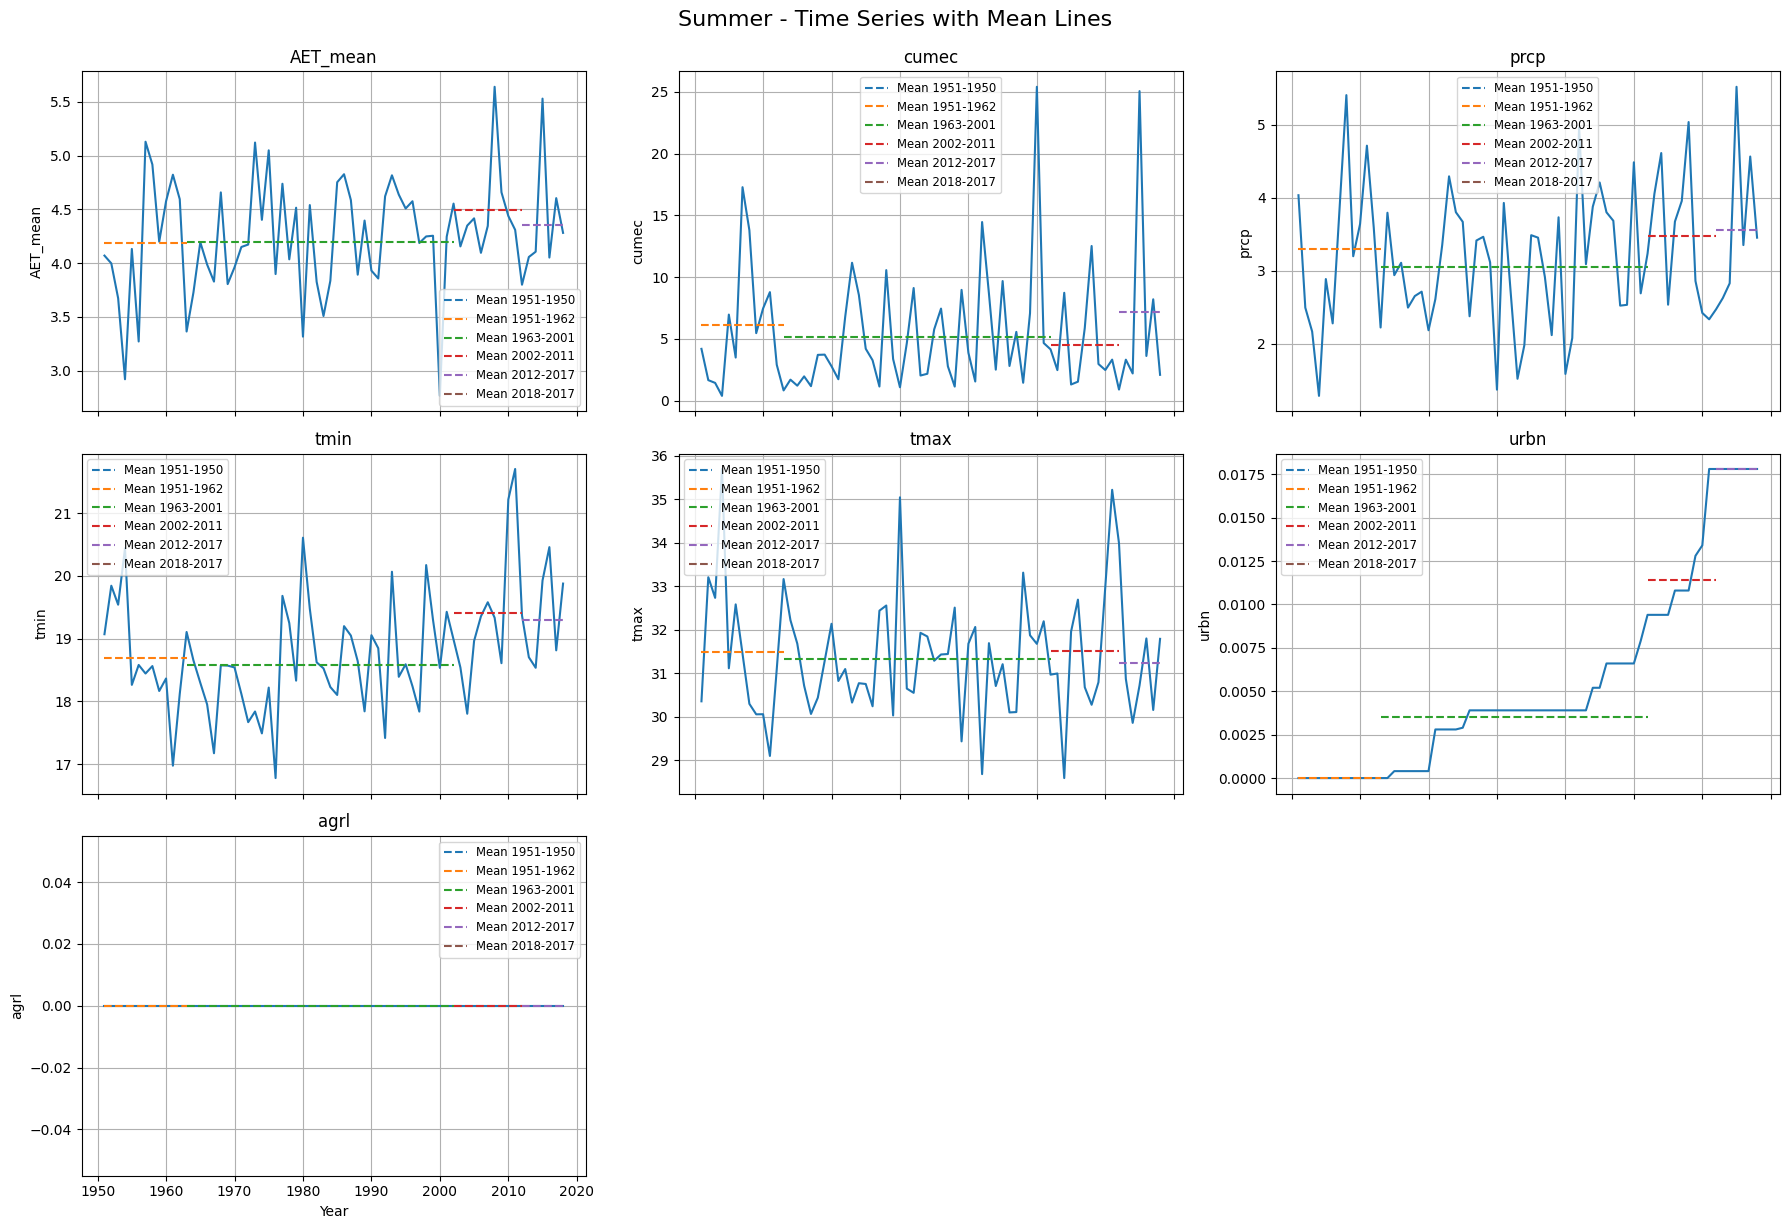


=== Processing Season: Winter ===
Filtered Turning Points: [1951, 1964, 1979, 1993, 2018]
Intervals: [(1951, 1964), (1964, 1979), (1979, 1993), (1993, 2018)]


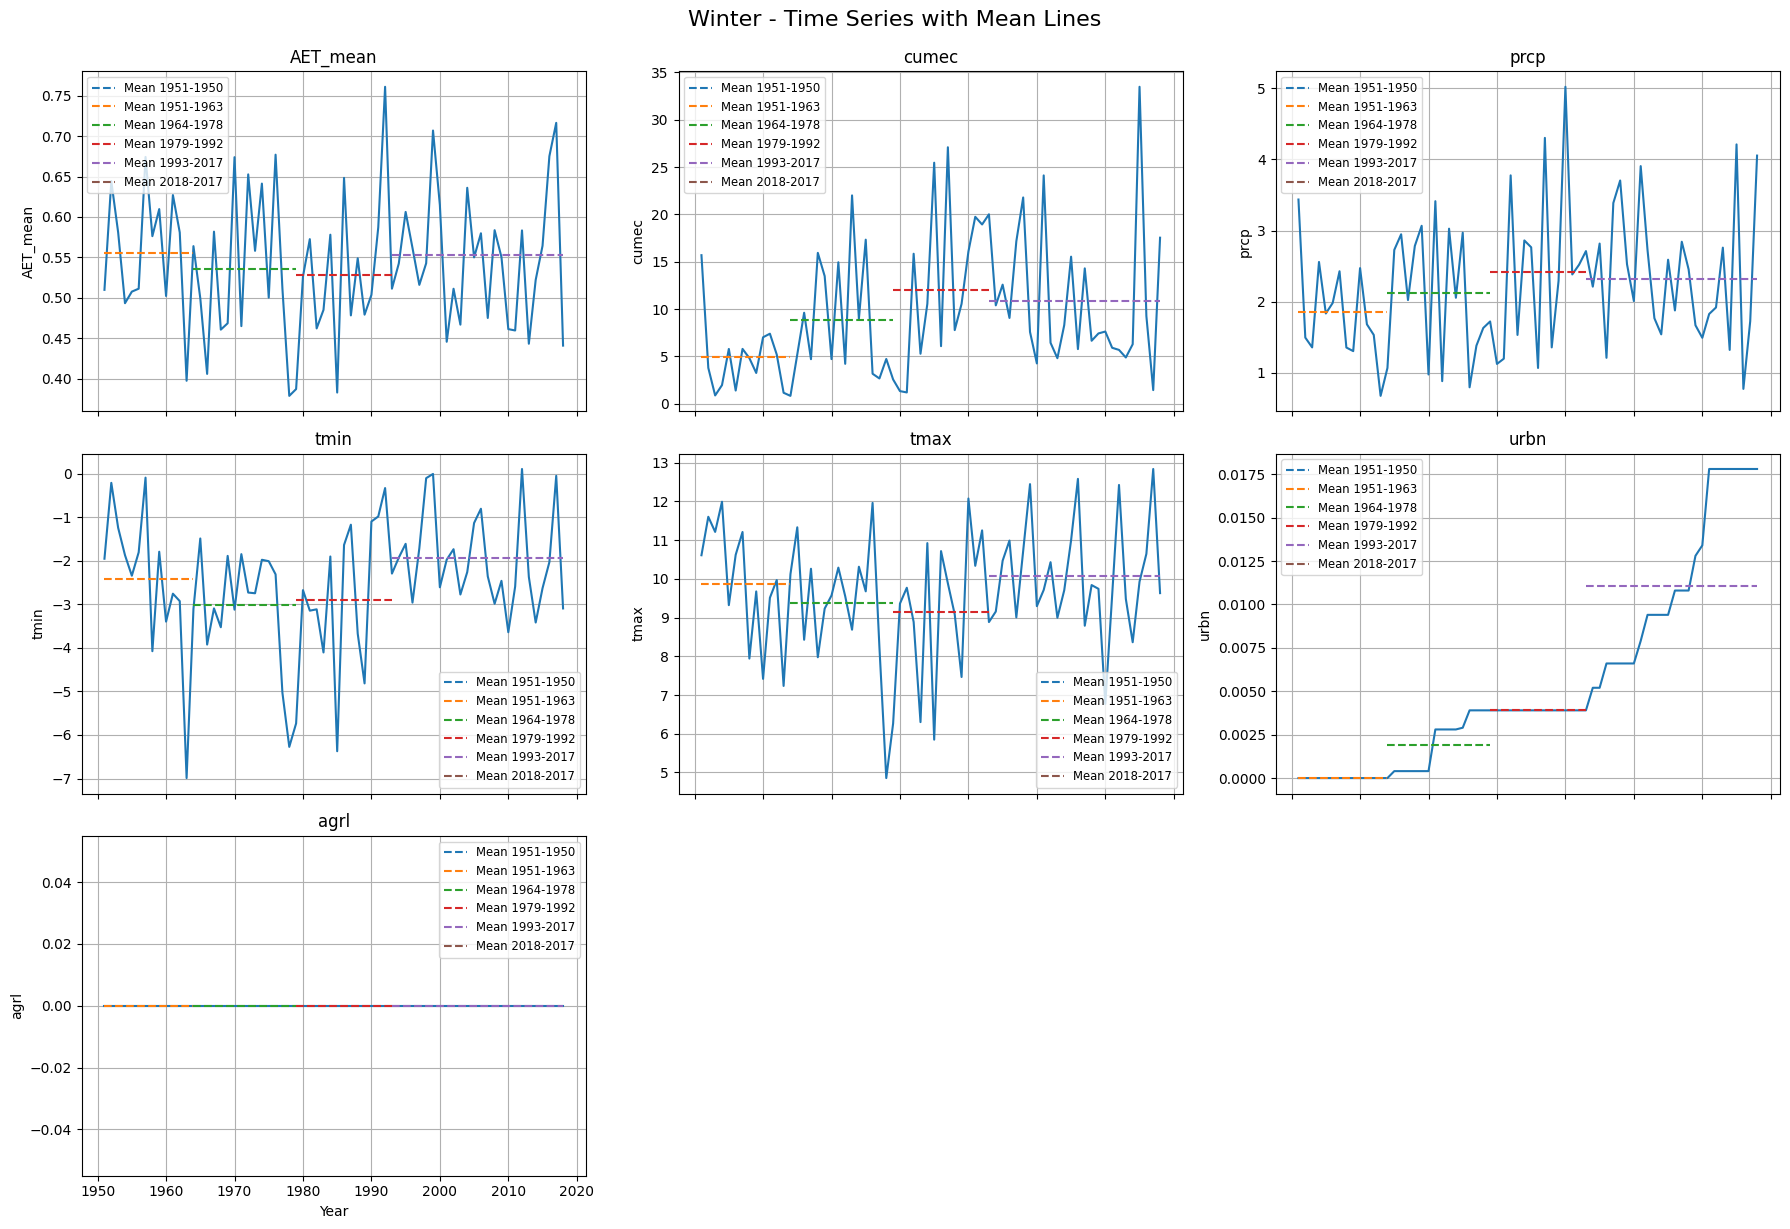


=== Processing Season: Spring ===
Filtered Turning Points: [1951, 1963, 1979, 1990, 2007, 2018]
Intervals: [(1951, 1963), (1963, 1979), (1979, 1990), (1990, 2007), (2007, 2018)]


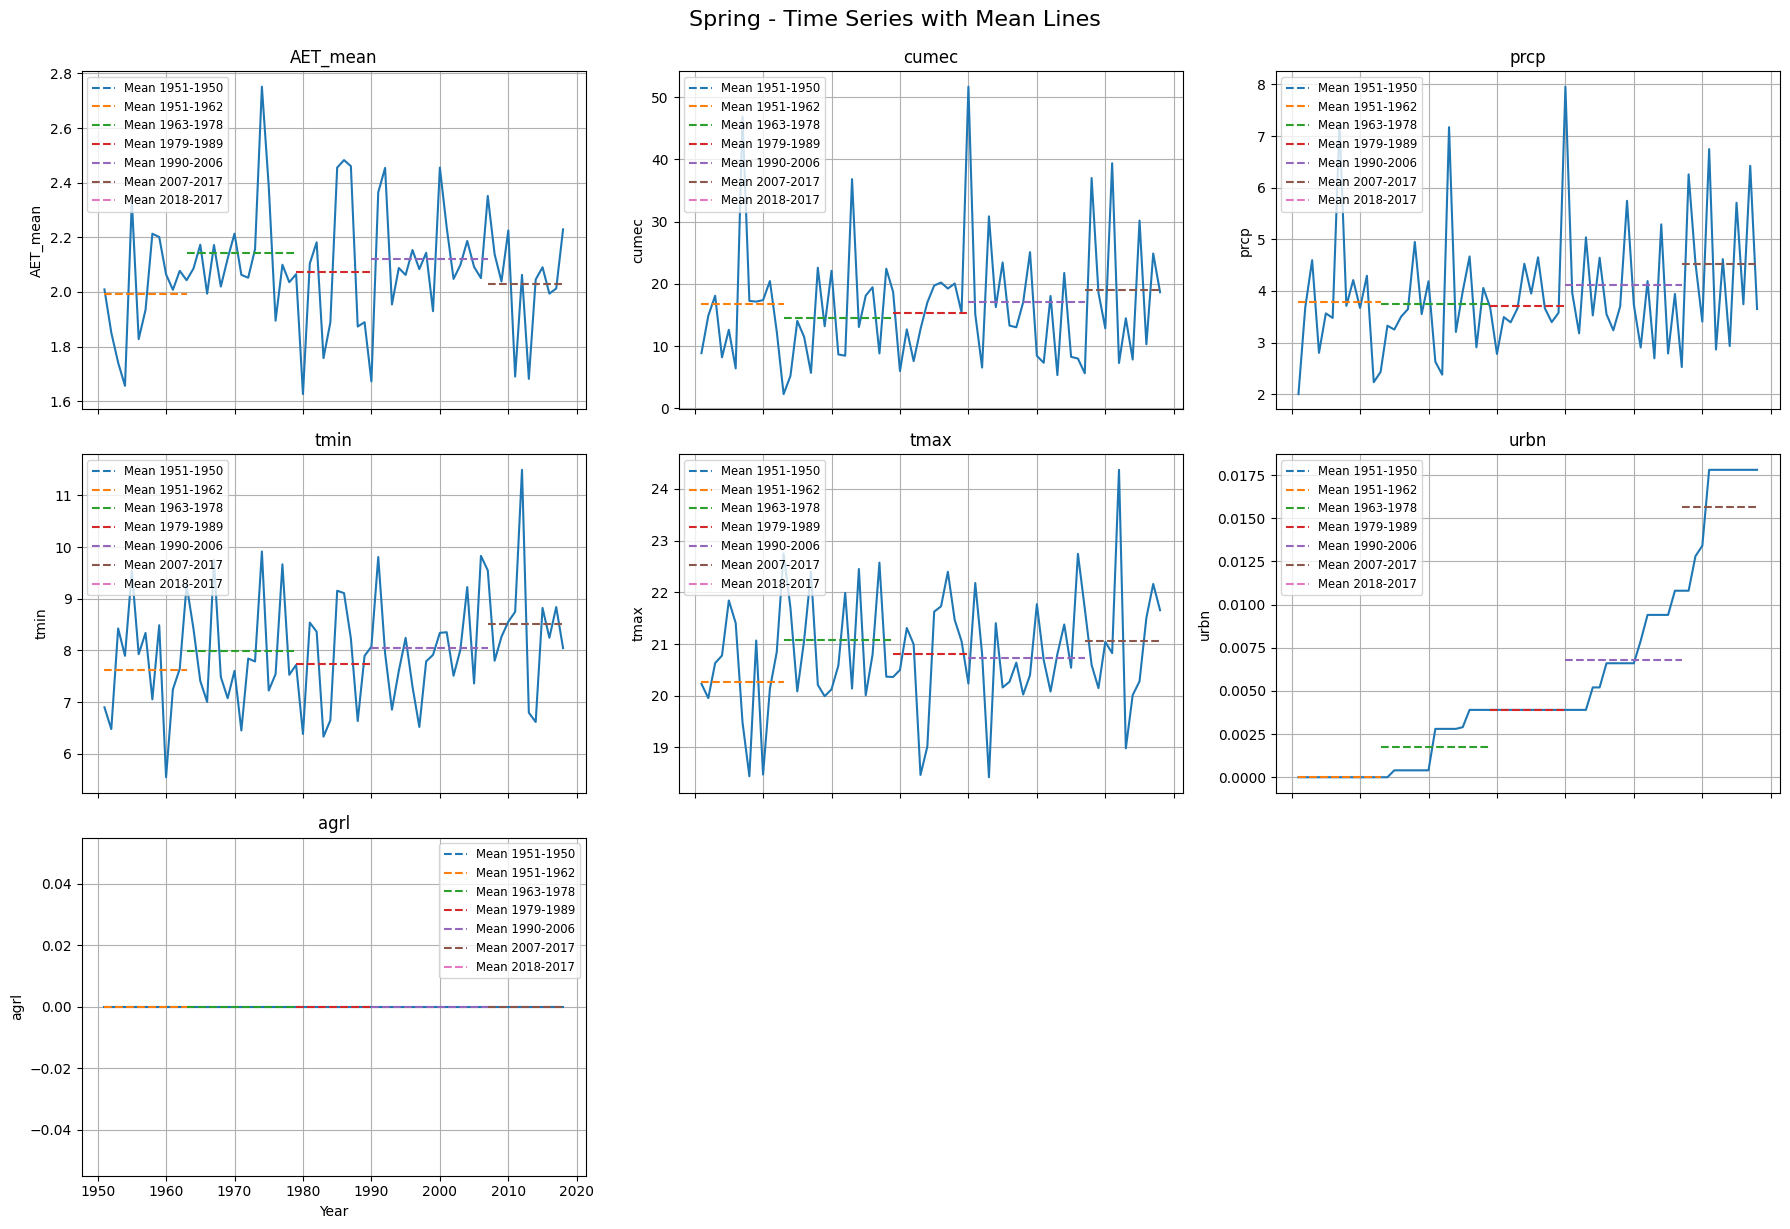


=== Processing Season: Autumn ===
Filtered Turning Points: [1951, 1965, 1980, 1993, 2006, 2018]
Intervals: [(1951, 1965), (1965, 1980), (1980, 1993), (1993, 2006), (2006, 2018)]


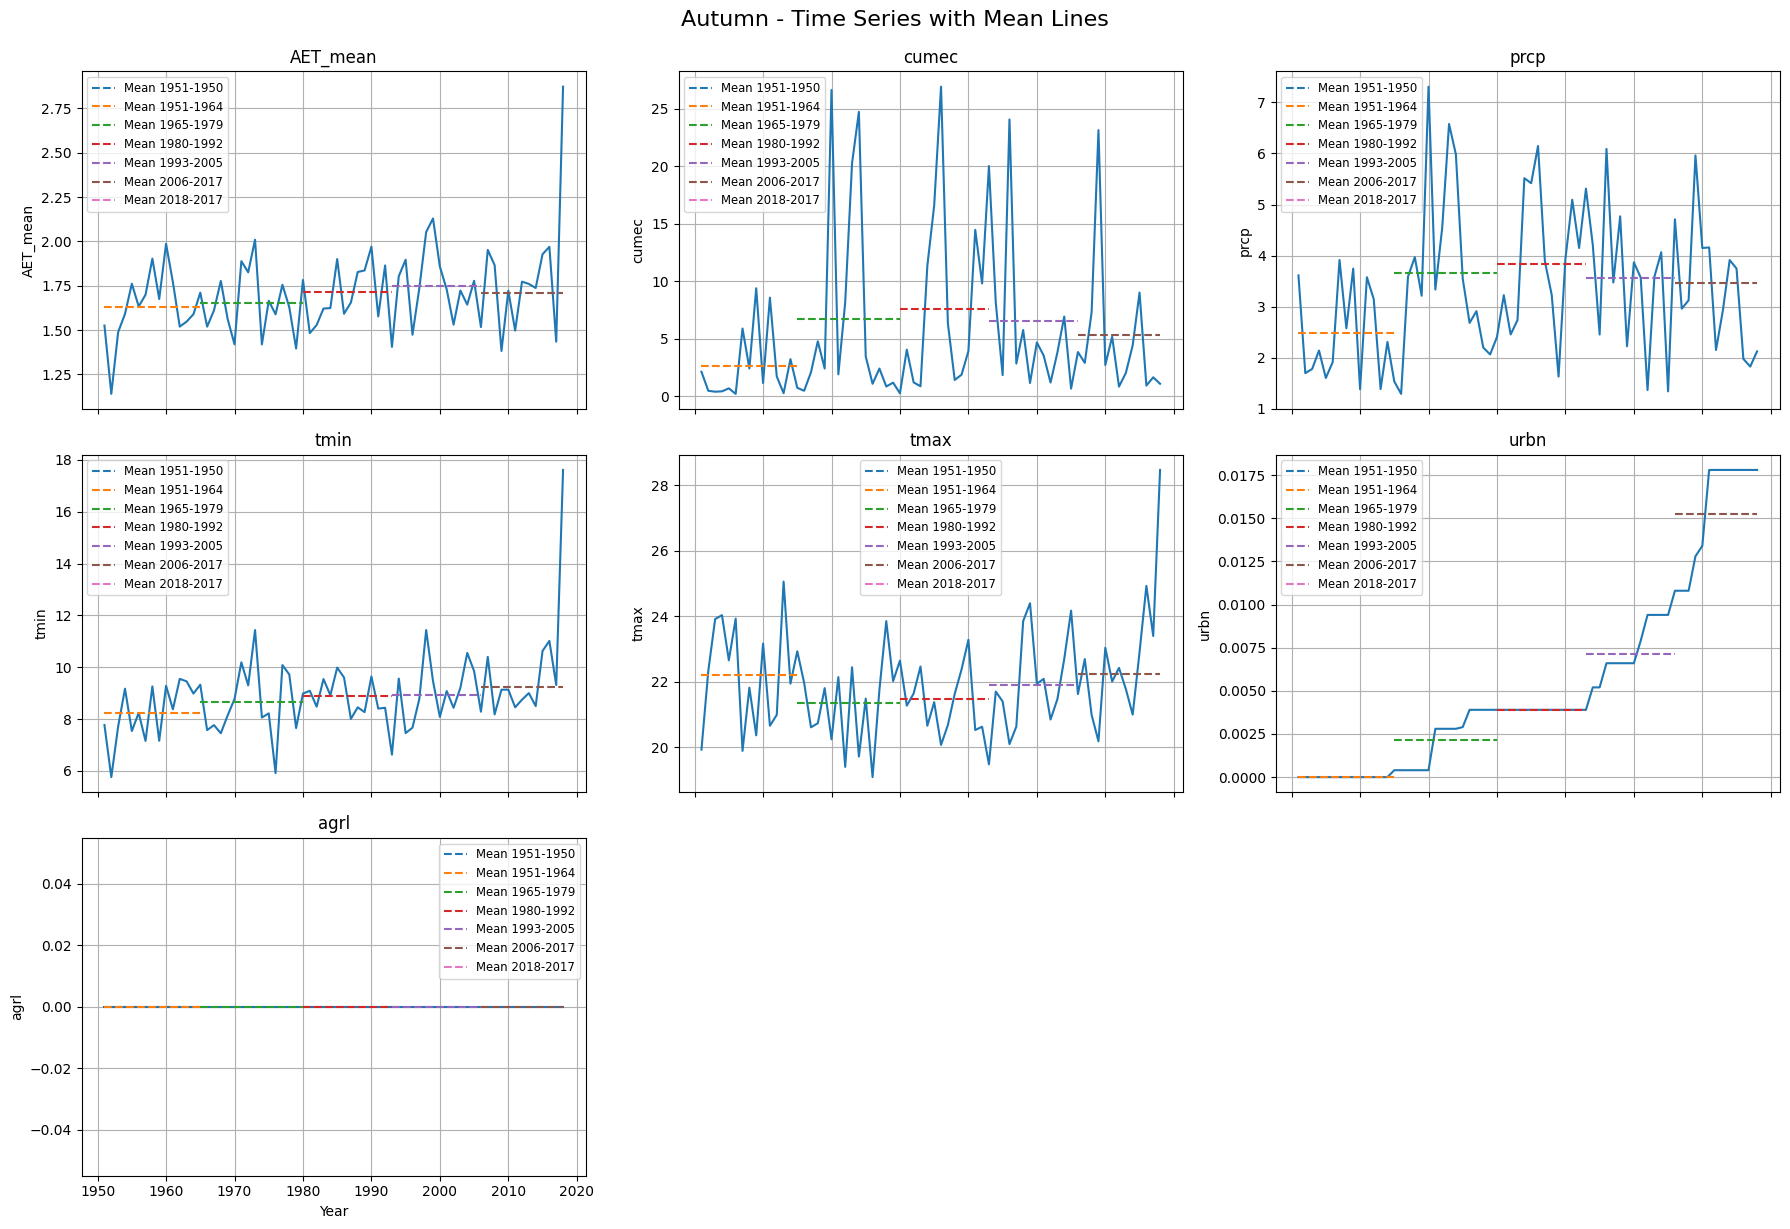

In [135]:
Interval_summer = process_season(summer_df, "Summer")
Interval_winter = process_season(winter_df, "Winter")
Interval_spring = process_season(spring_df, "Spring")
Interval_autumn = process_season(autumn_df, "Autumn")

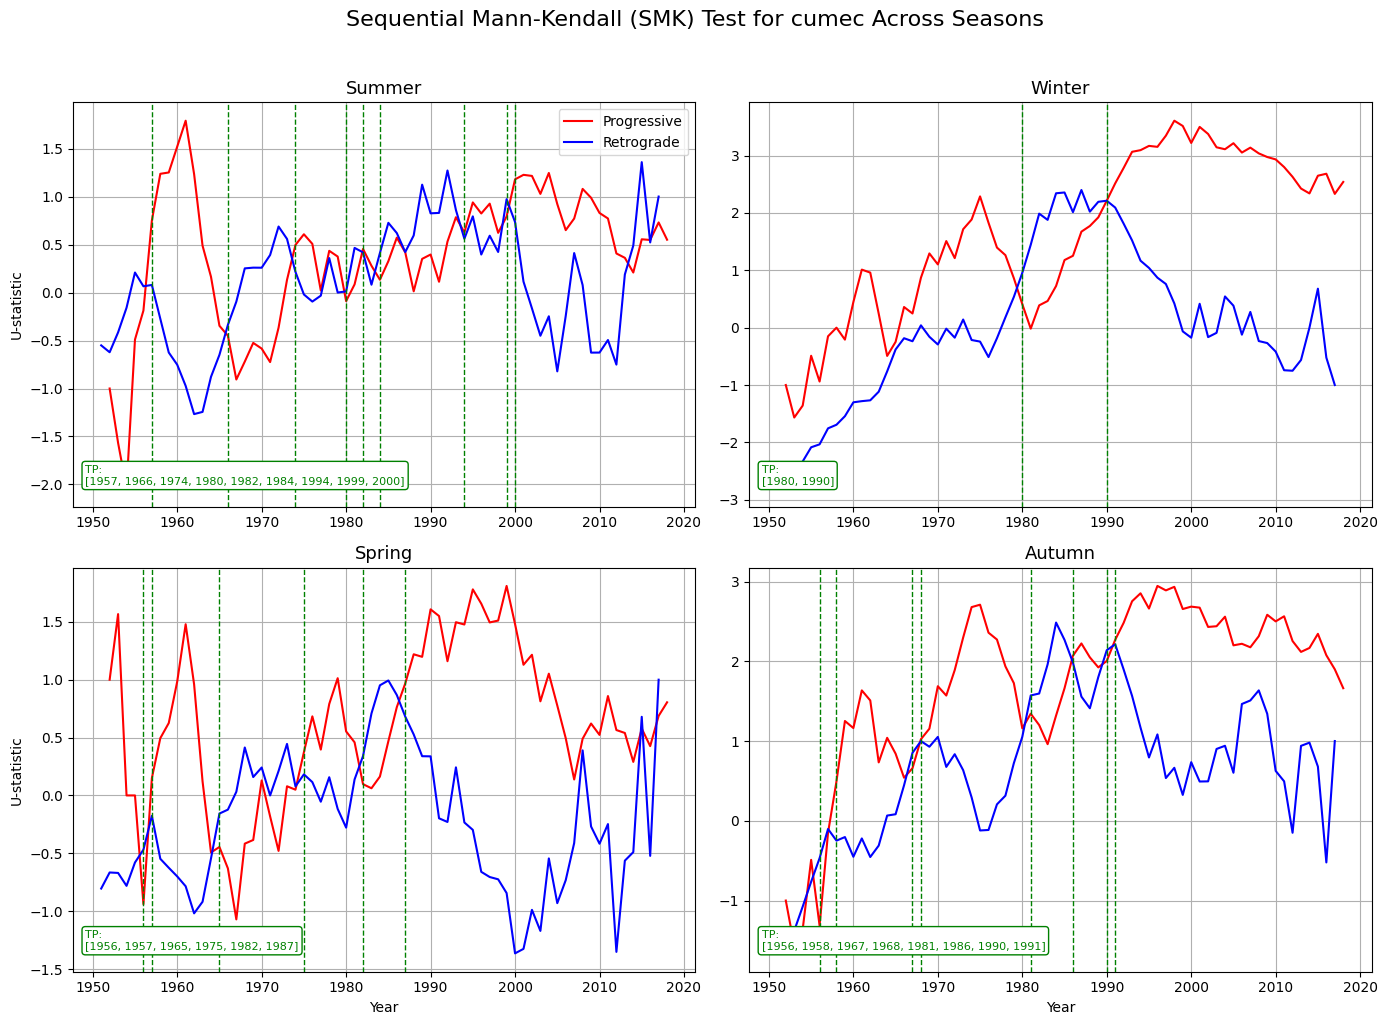

In [136]:
def plot_all_seasons_cumec(season_dfs, season_names):
    feature = 'cumec'
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, (df_season, season_name) in enumerate(zip(season_dfs, season_names)):
        ax = axes[idx]

        # Prepare data
        data_array = df_season[['year', feature]].to_numpy()
        result = seq_mk(data_array)

        year = result['year']
        u_prog = result['u_prog']
        u_retr = result['u_retr']

        # Exclude first and last 5 years
        min_year, max_year = year.min(), year.max()
        exclude_range = 4
        valid_turning = sorted(set(
            result[
                (result['turning_point'] == 1) &
                (result['year'] > min_year + exclude_range) &
                (result['year'] < max_year - exclude_range)
            ]['year'].astype(int)
        ))

        # Plot U-statistics
        ax.plot(year, u_prog, 'r', label='Progressive')
        ax.plot(year, u_retr, 'b', label='Retrograde')

        # Plot vertical lines for turning points
        for ty in valid_turning:
            ax.axvline(ty, color='green', linestyle='--', linewidth=1)

        # Add turning points as text
        tp_text = f"TP:\n{valid_turning}"
        ax.text(0.02, 0.05, tp_text,
                transform=ax.transAxes,
                fontsize=8, color='green',
                verticalalignment='bottom',
                bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

        ax.set_title(f"{season_name}", fontsize=13)
        ax.grid(True)

        if idx in [0, 2]:  # Left column
            ax.set_ylabel("U-statistic")
        if idx in [2, 3]:  # Bottom row
            ax.set_xlabel("Year")

    # Hide any extra subplots if fewer than 4
    for j in range(len(season_dfs), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Sequential Mann-Kendall (SMK) Test for cumec Across Seasons", fontsize=16, y=1.02)
    axes[0].legend(loc='upper right')
    plt.tight_layout()
    plt.show()

season_dfs = [summer_df, winter_df, spring_df, autumn_df]
season_names = ["Summer", "Winter", "Spring", "Autumn"]

plot_all_seasons_cumec(season_dfs, season_names)


Processing interval 1951-1963 for Summer...
Processing interval 1963-2002 for Summer...
Processing interval 2002-2012 for Summer...
Processing interval 2012-2018 for Summer...


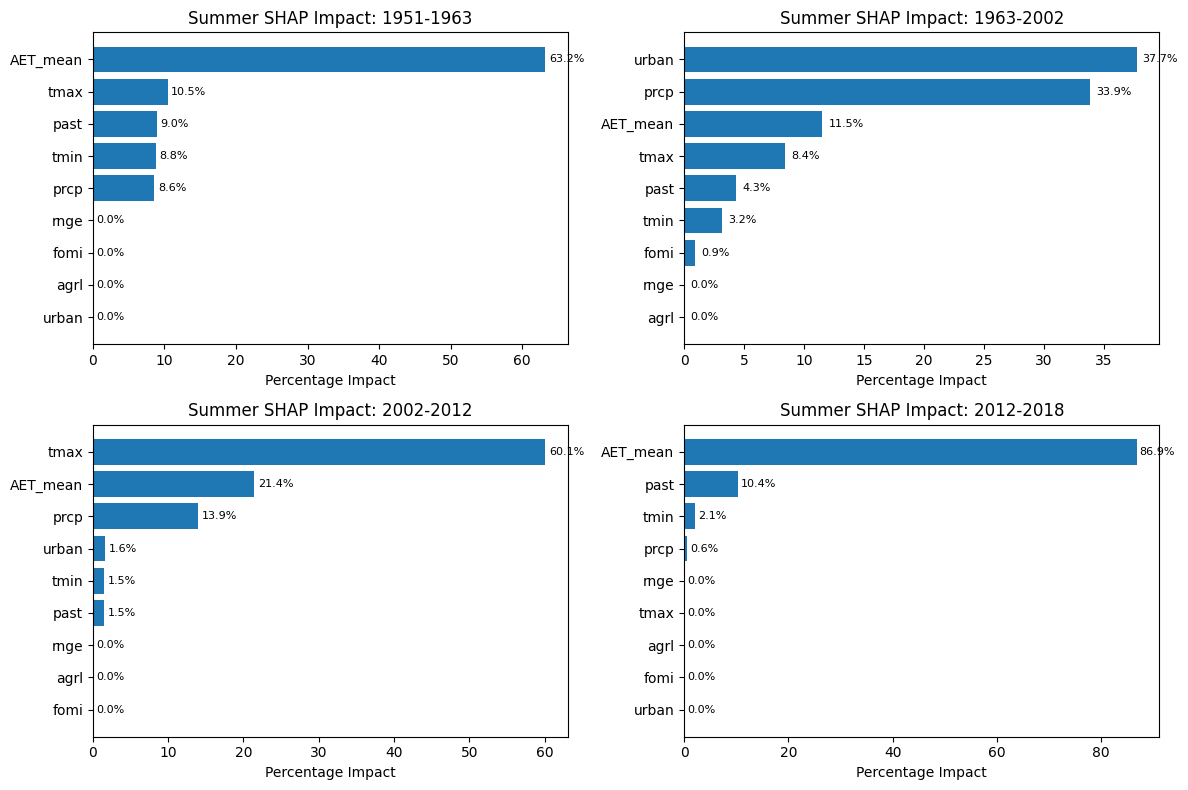

Processing interval 1951-1964 for Winter...
Processing interval 1964-1979 for Winter...
Processing interval 1979-1993 for Winter...
Processing interval 1993-2018 for Winter...


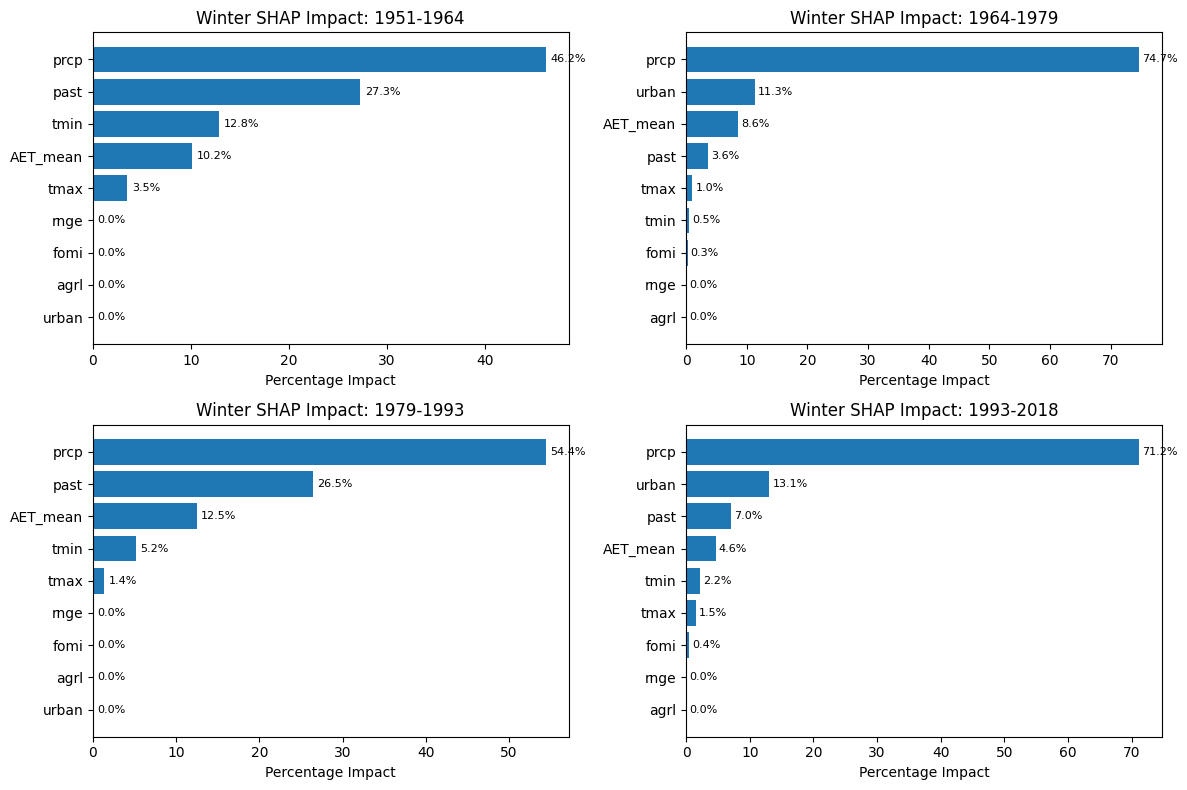

Processing interval 1951-1963 for Spring...
Processing interval 1963-1979 for Spring...
Processing interval 1979-1990 for Spring...
Processing interval 1990-2007 for Spring...
Processing interval 2007-2018 for Spring...


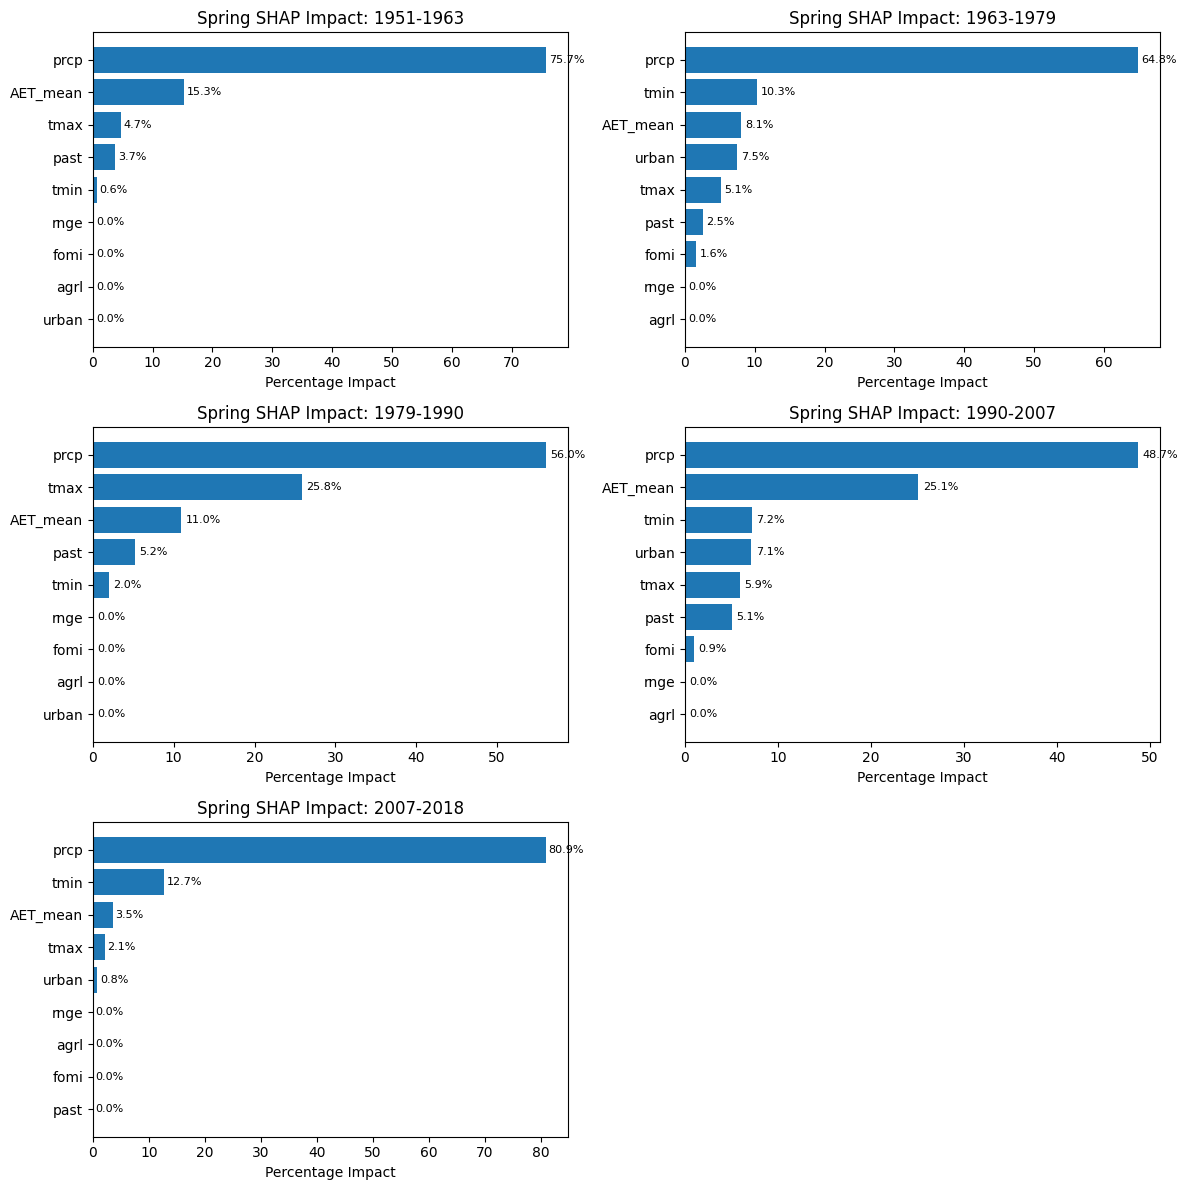

Processing interval 1951-1965 for Autumn...
Processing interval 1965-1980 for Autumn...
Processing interval 1980-1993 for Autumn...
Processing interval 1993-2006 for Autumn...
Processing interval 2006-2018 for Autumn...


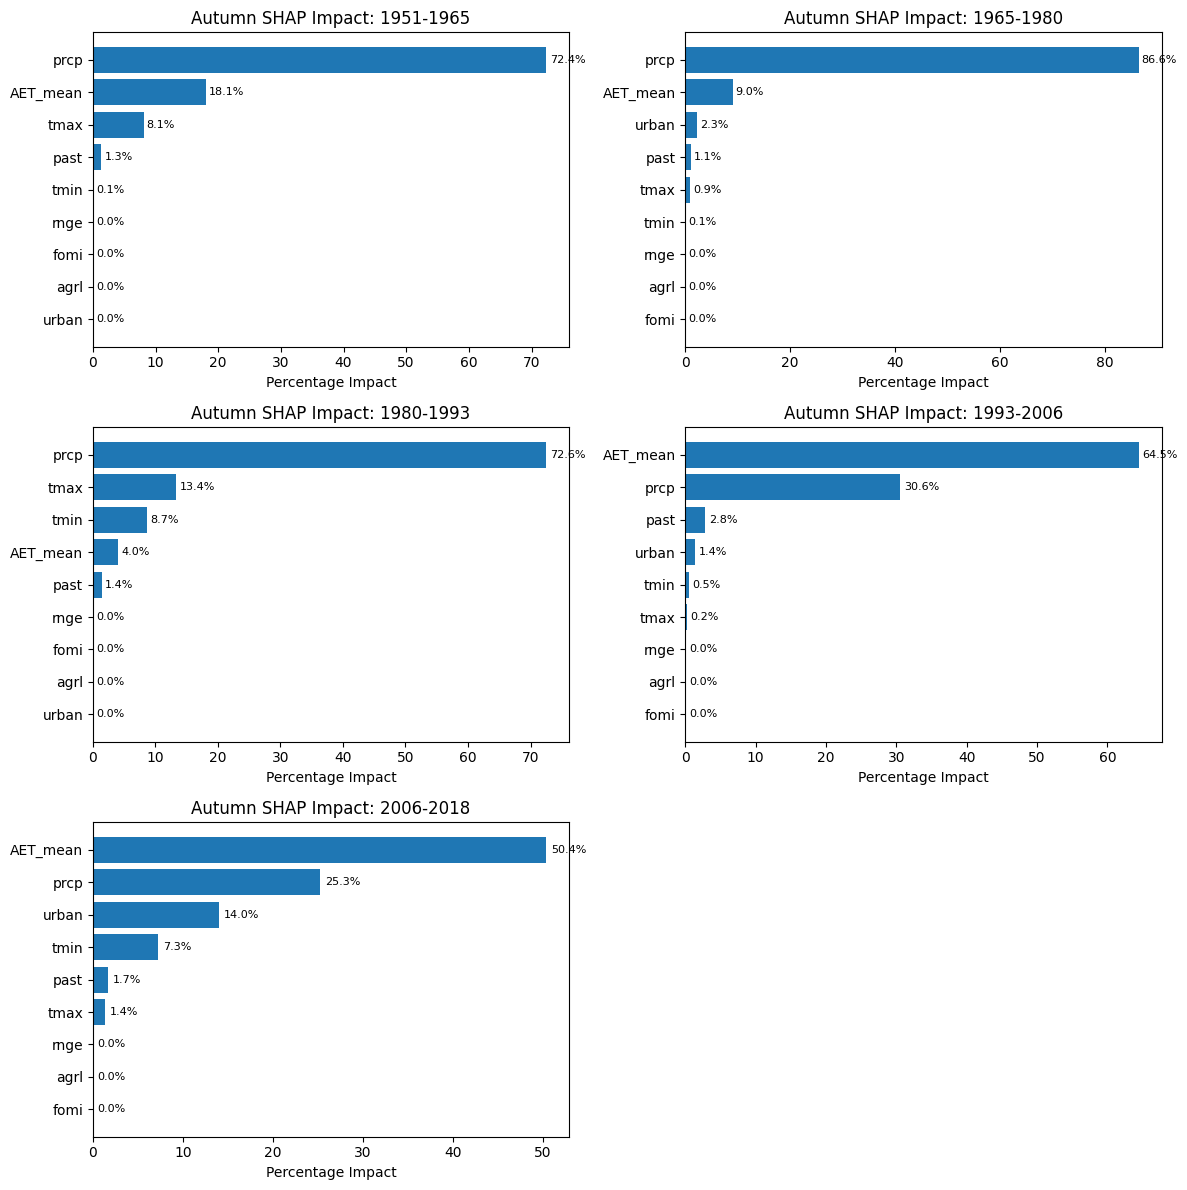

In [137]:
# Function to compute percentage impact
def get_percentage_impact(shap_vals, columns, group_map):
    df_shap = pd.DataFrame(shap_vals, columns=columns)
    grouped_shap = {}

    for group_name, feature_list in group_map.items():
        grouped_shap[group_name] = df_shap[feature_list].abs().sum(axis=1)

    for col in columns:
        if not any(col in v for v in group_map.values()):
            grouped_shap[col] = df_shap[col].abs()

    grouped_df = pd.DataFrame(grouped_shap)
    mean_abs = grouped_df.mean()
    pct = 100 * mean_abs / mean_abs.sum()
    return pct.sort_values()

# Function for model training, SHAP computation, and plotting for a given season
def train_and_plot_shap(df_season, season_name, intervals, features, target, group_map, best_params):
    interval_importances = {}

    for start, end in intervals:
        print(f"Processing interval {start}-{end} for {season_name}...")

        df_interval = df_season[(df_season['year'] >= start) & (df_season['year'] < end)]
        X = df_interval[features].copy()
        y = df_interval[target]

        if X.empty:
            print(f"Skipped {start}-{end} due to no data.")
            continue

        bool_cols = X.select_dtypes(include='bool').columns
        X[bool_cols] = X[bool_cols].astype(int)

        model = xgb.XGBRegressor(**best_params, random_state=42)
        model.fit(X, y)

        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)

        shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values

        impact = get_percentage_impact(shap_vals, features, group_map)
        interval_importances[f"{start}-{end}"] = impact

    # Plotting
    n_intervals = len(interval_importances)
    if n_intervals == 0:
        #print(f"No valid intervals for {season_name}. Skipping plot.")
        return

    n_cols = 2
    n_rows = math.ceil(n_intervals / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=False)
    axes = axes.flatten()

    for ax, (interval, imp) in zip(axes, interval_importances.items()):
        ax.barh(imp.index, imp.values)
        ax.set_title(f"{season_name} SHAP Impact: {interval}")
        ax.set_xlabel("Percentage Impact")
        for i, v in enumerate(imp.values):
            ax.text(v + 0.5, i, f"{v:.1f}%", va='center', fontsize=8)

    # Remove unused subplots
    for i in range(len(interval_importances), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

features = [col for col in df_monthly.columns if col not in ['year', 'cumec', 'Baseflow(cumec)', 'month','season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter']]
target = 'cumec'
group_map = {
    "urban": ["urban_precip", "urbn", "urban_tmin"]
}
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

season_dfs = [summer_df, winter_df, spring_df, autumn_df]
season_names = ["Summer", "Winter", "Spring", "Autumn"]
intervals_list = [Interval_summer, Interval_winter, Interval_spring, Interval_autumn]

# Loop through each season
for df_season, season_name, intervals in zip(season_dfs, season_names, intervals_list):
    train_and_plot_shap(df_season, season_name, intervals, features, target, group_map, best_params)

